In [1]:
from importlib import reload
#reload(Utilities)
#reload(clm)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns
from packaging import version
i
import itertools

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
from Utilities_df import DFConstructType
import Plot_General
import Plot_Box_sns
import GrubbsTest

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
#-----
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#-----
import scipy
from scipy import signal
#-----
from tensorflow import keras
#-----
# from tslearn.shapelets import LearningShapelets

In [3]:
# import fbprophet

In [4]:
from alibi_detect.od import OutlierProphet
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector

C:\Users\s346557\Anaconda3\envs\fbprophet\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [5]:
from itertools import product
def get_outg_confusion_matrix_text_colors(
    cmd
):
    r"""
    Basically taken from sklearn.metrics.ConfusionMatrixDisplay.plot
    Colors are needed so my additional text matches what's provided by sklearn method.
    
    SHOULD BE CALLED AFTER sklearn.metrics.ConfusionMatrixDisplay.plot!
    """
    #-------------------------
    cm = cmd.confusion_matrix
    assert(cm.shape[0]==2)
    n_classes = cm.shape[0]
    #-------------------------
    cmap_min, cmap_max = cmd.im_.cmap(0), cmd.im_.cmap(1.0)
    thresh = (cm.max() + cm.min()) / 2.0
    #-------------------------
    colors = np.empty((2,2), dtype=object)
    for i,j in product(range(2), range(2)):
        color = cmap_max if cm[i, j] < thresh else cmap_min
        colors[i,j] = color
    #-------------------------
    return colors

In [6]:
def draw_confusion_matrix(
    y, 
    y_pred, 
    title=None, 
    normalize=None, 
    scientific=True, 
    ax=None, 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='Outage', 
    target_eq_0_name='Baseline'
):
    r"""
    Visualize confusion matrix for outages using sklearn.metrics.ConfusionMatrixDisplay
    """
    #-------------------------
    cmd = ConfusionMatrixDisplay(
        confusion_matrix(y, y_pred, normalize=normalize), 
        display_labels=[target_eq_0_name, target_eq_1_name]
    )
    #-----
    if scientific:
        cmd.plot(values_format='.3e', ax=ax, text_kw=text_kw)
    else:
        cmd.plot(values_format='', ax=ax, text_kw=text_kw)
    #-------------------------
    cmd.ax_.set_xlabel('Predicted', fontsize='xx-large')
    cmd.ax_.set_ylabel('True', fontsize='xx-large')
    cmd.ax_.set_title(title, fontsize='xx-large', fontweight='semibold')
    #ax.set_size_inches(12, 10)
    #-------------------------
    if scientific:
        txt_fmt     = '{:.4e}'
        pct_txt_fmt = txt_fmt
    else:
        txt_fmt     = '{}'
        pct_txt_fmt = '{:.4f}'
    #-----
    ax = cmd.ax_
    ax.text(1.5, 0.9, "# Entries:  {}".format(txt_fmt).format(y.shape[0]), fontsize=14, transform=ax.transAxes)
    ax.text(1.5, 0.8, "# {}:  {}".format(target_eq_1_name, txt_fmt).format(y.sum()), fontsize=14, transform=ax.transAxes)
    ax.text(1.5, 0.7, "# {}: {}".format(target_eq_0_name, txt_fmt).format(y.shape[0]-y.sum()), fontsize=14, transform=ax.transAxes)
    ax.text(1.5, 0.6, "% {}:  {}".format(target_eq_1_name, pct_txt_fmt).format(100*y.sum()/y.shape[0]), fontsize=14, transform=ax.transAxes)
    #-------------------------
    ax.text(1.5, 0.4, "ACCURACY:  {:.4f}".format(accuracy_score(y, y_pred)), fontsize=14, transform=ax.transAxes)
    ax.text(1.5, 0.3, "PRECISION:  {:.4f}".format(precision_score(y, y_pred)), fontsize=14, transform=ax.transAxes)
    ax.text(1.5, 0.2, "RECALL:       {:.4f}".format(recall_score(y, y_pred)), fontsize=14, transform=ax.transAxes)
    ax.text(1.5, 0.1, "F1:               {:.4f}".format(f1_score(y, y_pred)), fontsize=14, transform=ax.transAxes)
    #--------------------------------------------------
    # Include TN, FP, FN, TP labels
    # NOTES:
    #   Text stored in cmd.text_ is stored in row-major fashion
    #   Therefore, when plotting the value, the y-value corresponds to the 0th
    #     index and the x-value corresponds to the 1st index
    #
    #   Axes are defined with limits:
    #     x_lim = (-0.5, 1.5)
    #     y_lim = (1.5, -0.5)
    #   The axes are defined such that: 
    #     top-left corner     = (-0.5, -0.5)
    #     bottom-right corner = (1.5, 1.5) 
    #-----
    colors = get_outg_confusion_matrix_text_colors(cmd)
    cat_fontsize = text_kw.get('fontsize', 'xx-large')
    #-----
    cmd.ax_.text(0,   -0.25, 'TN', ha='center', va='center', color=colors[0,0], fontweight='bold', fontsize=cat_fontsize)
    cmd.ax_.text(1.0, -0.25, 'FP', ha='center', va='center', color=colors[0,1], fontweight='bold', fontsize=cat_fontsize)

    cmd.ax_.text(0,    0.75, 'FN', ha='center', va='center', color=colors[1,0], fontweight='bold', fontsize=cat_fontsize)
    cmd.ax_.text(1.0,  0.75, 'TP', ha='center', va='center', color=colors[1,1], fontweight='bold', fontsize=cat_fontsize)    
    #--------------------------------------------------
    #return ax, cmd.ax_
    return cmd

In [7]:
def remove_ev_submeter_in_pair(
    ami_df_i, 
    pct_0_thresh_main=0.1, 
    pct_0_thresh_subm=0.6, 
    enforce_corr=True, 
    corr_thresh=0.5, 
    #remove_undetermined=True, 
    value_col='value', 
    time_col='index', 
    PN_col='aep_premise_nb', 
    SN_col='serialnumber'
):
    r"""
    Given a pair of meter connected to a single premise, this tries to determine which is the EV submeter in the pair, 
      and keeps that which is not.
    Basically, the submeter only monitors the EV, whereas the other monitors the usage of the entire premise.
    Thus, the EV signal should be 0 for a majority of the time, and the two meters should be correlated.
    
    This is a somewhat specialized function for use with engineering the EV dataset
    
    ami_df_i:
        An AMI DF containing data for a single premise which has two meters
        
    pct_0_thresh_main:
        The maximum allowed percentage of 0 values for a meter to be considered the main meter
    pct_0_thresh_subm:
        The minimum allowed percentage of 0 values for a meter to be considered the submeter
    """
    #-------------------------
    assert(ami_df_i[PN_col].nunique()==1)
    assert(pct_0_thresh_main < pct_0_thresh_subm)
    #-------------------------
    SNs_i = ami_df_i[SN_col].unique().tolist()
    assert(len(SNs_i)<=2)
    #-------------------------
    if len(SNs_i)==1:
        return ami_df_i
    #-------------------------
    ami_df_i_1 = ami_df_i[ami_df_i[SN_col]==SNs_i[0]]
    ami_df_i_2 = ami_df_i[ami_df_i[SN_col]==SNs_i[1]]
    if time_col=='index':
        ami_df_i_1 = ami_df_i_1.sort_index()
        ami_df_i_2 = ami_df_i_2.sort_index()
    else:
        ami_df_i_1 = ami_df_i_1.sort_values(by=[time_col])
        ami_df_i_2 = ami_df_i_2.sort_values(by=[time_col])
    #--------------------------------------------------
    # NOTE: I have seen some SNs which have a bunch of 0.002 values, which, for the purposes here should be treated as 0s
    #       This is why I use <0.005 instead of ==0 and >=0.005 instead of !=0 below
    #--------------------------------------------------
    pct_1 = (ami_df_i_1[value_col]<0.005).sum()/ami_df_i_1.shape[0]
    pct_2 = (ami_df_i_2[value_col]<0.005).sum()/ami_df_i_2.shape[0]
    #-------------------------
    if pct_1 <= pct_0_thresh_main:
        defn_1 = 1
    elif pct_1 >= pct_0_thresh_subm:
        defn_1 = 0
    else:
        defn_1 = -1
    #-----
    if pct_2 <= pct_0_thresh_main:
        defn_2 = 1
    elif pct_2 >= pct_0_thresh_subm:
        defn_2 = 0
    else:
        defn_2 = -1
    #-------------------------
    if defn_1+defn_2==1:
        pass_pcts=True
    else:
        pass_pcts=False
    #-------------------------
    if not pass_pcts:
        return
    
    #--------------------------------------------------
    pass_corr=True
    if enforce_corr:
        if time_col=='index':
            ami_df_i_12 = pd.merge(ami_df_i_1[value_col], ami_df_i_2[value_col], left_index=True, right_index=True, how='outer')
        else:
            ami_df_i_12 = pd.merge(ami_df_i_1[value_col], ami_df_i_2[value_col], left_on=time_col, right_on=time_col, how='outer')
        # For the correlation only using values which are non-zero (and aligning, meaning non-NaN)
        ami_df_i_12 = ami_df_i_12[(ami_df_i_12[f'{value_col}_x']>=0.005) & (ami_df_i_12[f'{value_col}_y']>=0.005)]
        corr_val = ami_df_i_12[f'{value_col}_x'].corr(ami_df_i_12[f'{value_col}_y'])
        if corr_val >= corr_thresh:
            pass_corr = True
        else:
            pass_corr = False
            
    #--------------------------------------------------
    if not (pass_pcts and pass_corr):
        return
    #-------------------------
    if defn_1==1:
        assert(defn_2==0) # Sanity check, not needed
        return ami_df_i[ami_df_i[SN_col]==SNs_i[0]]
    else:
        assert(defn_1==0 and defn_2==1) # Sanity check, not needed
        return ami_df_i[ami_df_i[SN_col]==SNs_i[1]]

In [8]:
def select_pairs_w_submeter(
    ami_df_i, 
    pct_0_thresh_main=0.1, 
    pct_0_thresh_subm=0.6, 
    enforce_corr=True, 
    corr_thresh=0.5, 
    #remove_undetermined=True, 
    value_col='value', 
    time_col='index', 
    PN_col='aep_premise_nb', 
    SN_col='serialnumber'
):
    r"""
    Given a pair of meter connected to a single premise, this tries to determine which is the EV submeter in the pair, 
      and keeps that which is not.
    Basically, the submeter only monitors the EV, whereas the other monitors the usage of the entire premise.
    Thus, the EV signal should be 0 for a majority of the time, and the two meters should be correlated.
    
    This is a somewhat specialized function for use with engineering the EV dataset
    
    ami_df_i:
        An AMI DF containing data for a single premise which has two meters
        
    pct_0_thresh_main:
        The maximum allowed percentage of 0 values for a meter to be considered the main meter
    pct_0_thresh_subm:
        The minimum allowed percentage of 0 values for a meter to be considered the submeter
    """
    #-------------------------
    assert(ami_df_i[PN_col].nunique()==1)
    assert(pct_0_thresh_main < pct_0_thresh_subm)
    #-------------------------
    SNs_i = ami_df_i[SN_col].unique().tolist()
    assert(len(SNs_i)<=2)
    #-------------------------
    if len(SNs_i)==1:
        return 
    #-------------------------
    ami_df_i_1 = ami_df_i[ami_df_i[SN_col]==SNs_i[0]]
    ami_df_i_2 = ami_df_i[ami_df_i[SN_col]==SNs_i[1]]
    if time_col=='index':
        ami_df_i_1 = ami_df_i_1.sort_index()
        ami_df_i_2 = ami_df_i_2.sort_index()
    else:
        ami_df_i_1 = ami_df_i_1.sort_values(by=[time_col])
        ami_df_i_2 = ami_df_i_2.sort_values(by=[time_col])
    #--------------------------------------------------
    # NOTE: I have seen some SNs which have a bunch of 0.002 values, which, for the purposes here should be treated as 0s
    #       This is why I use <0.005 instead of ==0 and >=0.005 instead of !=0 below
    #--------------------------------------------------
    pct_1 = (ami_df_i_1[value_col]<0.005).sum()/ami_df_i_1.shape[0]
    pct_2 = (ami_df_i_2[value_col]<0.005).sum()/ami_df_i_2.shape[0]
    #-------------------------
    if pct_1 <= pct_0_thresh_main:
        defn_1 = 1
    elif pct_1 >= pct_0_thresh_subm:
        defn_1 = 0
    else:
        defn_1 = -1
    #-----
    if pct_2 <= pct_0_thresh_main:
        defn_2 = 1
    elif pct_2 >= pct_0_thresh_subm:
        defn_2 = 0
    else:
        defn_2 = -1
    #-------------------------
    if defn_1+defn_2==1:
        pass_pcts=True
    else:
        pass_pcts=False
    #-------------------------
    if not pass_pcts:
        return
    
    #--------------------------------------------------
    pass_corr=True
    if enforce_corr:
        if time_col=='index':
            ami_df_i_12 = pd.merge(ami_df_i_1[value_col], ami_df_i_2[value_col], left_index=True, right_index=True, how='outer')
        else:
            ami_df_i_12 = pd.merge(ami_df_i_1[value_col], ami_df_i_2[value_col], left_on=time_col, right_on=time_col, how='outer')
        # For the correlation only using values which are non-zero (and aligning, meaning non-NaN)
        ami_df_i_12 = ami_df_i_12[(ami_df_i_12[f'{value_col}_x']>=0.005) & (ami_df_i_12[f'{value_col}_y']>=0.005)]
        corr_val = ami_df_i_12[f'{value_col}_x'].corr(ami_df_i_12[f'{value_col}_y'])
        if corr_val >= corr_thresh:
            pass_corr = True
        else:
            pass_corr = False
            
    #--------------------------------------------------
    if not (pass_pcts and pass_corr):
        return
    #-------------------------
    if defn_1==1:
        assert(defn_2==0) # Sanity check, not needed
        ami_df_i_main = ami_df_i[ami_df_i[SN_col]==SNs_i[0]].copy()
        ami_df_i_subm = ami_df_i[ami_df_i[SN_col]==SNs_i[1]].copy()
    else:
        assert(defn_1==0 and defn_2==1) # Sanity check, not needed
        ami_df_i_main =  ami_df_i[ami_df_i[SN_col]==SNs_i[1]].copy()
        ami_df_i_subm =  ami_df_i[ami_df_i[SN_col]==SNs_i[0]].copy()
    #-------------------------
    if time_col=='index':
        return_ami_df_i = pd.merge(
            ami_df_i_main, 
            ami_df_i_subm[[value_col, SN_col]], 
            left_index=True, 
            right_index=True, 
            how='inner'
        )
    else:
        return_ami_df_i = pd.merge(
            ami_df_i_main, 
            ami_df_i_subm[[value_col, time_col, SN_col]], 
            left_on=time_col, 
            right_on=time_col, 
            how='inner'
        )
    #----------
    return_ami_df_i = return_ami_df_i.rename(columns={
        f'{value_col}_x': f'{value_col}_main', 
        f'{value_col}_y': f'{value_col}_subm', 
        f'{SN_col}_x': f'{SN_col}_main', 
        f'{SN_col}_y': f'{SN_col}_subm', 
    })
    #----------
    return_ami_df_i[f'{value_col}_delt'] = return_ami_df_i[f'{value_col}_main']-return_ami_df_i[f'{value_col}_subm']
    #-------------------------
    return return_ami_df_i

# SEE WEBPAGES
https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data
https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/43512887#43512887
https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/56451135#56451135

In [9]:
# class real_time_peak_detection():
#     def __init__(self, array, lag, threshold, influence):
#         self.y = list(array)
#         self.length = len(self.y)
#         self.lag = lag
#         self.threshold = threshold
#         self.influence = influence
#         self.signals = [0] * len(self.y)
#         self.filteredY = np.array(self.y).tolist()
#         self.avgFilter = [0] * len(self.y)
#         self.stdFilter = [0] * len(self.y)
#         self.avgFilter[self.lag - 1] = np.mean(self.y[0:self.lag]).tolist()
#         self.stdFilter[self.lag - 1] = np.std(self.y[0:self.lag]).tolist()

#     def thresholding_algo(self, new_value):
#         self.y.append(new_value)
#         i = len(self.y) - 1
#         self.length = len(self.y)
#         if i < self.lag:
#             return 0
#         elif i == self.lag:
#             self.signals = [0] * len(self.y)
#             self.filteredY = np.array(self.y).tolist()
#             self.avgFilter = [0] * len(self.y)
#             self.stdFilter = [0] * len(self.y)
#             self.avgFilter[self.lag] = np.mean(self.y[0:self.lag]).tolist()
#             self.stdFilter[self.lag] = np.std(self.y[0:self.lag]).tolist()
#             return 0

#         self.signals += [0]
#         self.filteredY += [0]
#         self.avgFilter += [0]
#         self.stdFilter += [0]

#         if abs(self.y[i] - self.avgFilter[i - 1]) > (self.threshold * self.stdFilter[i - 1]):

#             if self.y[i] > self.avgFilter[i - 1]:
#                 self.signals[i] = 1
#             else:
#                 self.signals[i] = -1

#             self.filteredY[i] = self.influence * self.y[i] + \
#                 (1 - self.influence) * self.filteredY[i - 1]
#             self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
#             self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])
#         else:
#             self.signals[i] = 0
#             self.filteredY[i] = self.y[i]
#             self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
#             self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])

#         return self.signals[i]


def thresholding_algo_OLD(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


def thresholding_algo(
    y, 
    lag, 
    threshold, 
    influence, 
    signal_abs_threshold=1.0
):
    #-----
    if len(y) < lag:
        return dict(signals = np.asarray(np.zeros(len(y))),
                    avgFilter = np.asarray(np.mean(y)),
                    stdFilter = np.asarray(np.std(y)))
    #-----
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    non_signal_Y = []
    for i in range(lag, len(y)):
        if y[i] < signal_abs_threshold:
            signals[i] = 0
            filteredY[i] = y[i]
            non_signal_Y.append(y[i])    
        else:
            if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter[i-1]:
                if y[i] > avgFilter[i-1]:
                    signals[i] = 1
                else:
                    signals[i] = -1
                if len(non_signal_Y)==0:
                    filteredY[i] = influence * y[i]
                else:
                    filteredY[i] = influence * y[i] + (1 - influence) * np.mean(non_signal_Y)
            else:
                signals[i] = 0
                filteredY[i] = y[i]
                non_signal_Y.append(y[i])
        avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
        stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [10]:
def thresholding_algo_median(
    y, 
    lag, 
    threshold, 
    influence, 
    signal_abs_threshold=1.0
):
    #-----
    if len(y) < lag:
        return dict(signals = np.asarray(np.zeros(len(y))),
                    avgFilter = np.asarray(np.median(y)),
                    stdFilter = np.asarray(np.std(y)))
    #-----
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.median(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    non_signal_Y = []
    for i in range(lag, len(y)):
        if y[i] < signal_abs_threshold:
            signals[i] = 0
            filteredY[i] = y[i]
            non_signal_Y.append(y[i])    
        else:
            if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter[i-1]:
                if y[i] > avgFilter[i-1]:
                    signals[i] = 1
                else:
                    signals[i] = -1
                if len(non_signal_Y)==0:
                    filteredY[i] = influence * y[i]
                else:
                    filteredY[i] = influence * y[i] + (1 - influence) * np.median(non_signal_Y)
            else:
                signals[i] = 0
                filteredY[i] = y[i]
                non_signal_Y.append(y[i])
        avgFilter[i] = np.median(filteredY[(i-lag+1):i+1])
        stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [11]:
def mad(y):
    return np.mean(np.abs(y - np.mean(y)))

def thresholding_algo_mad(
    y, 
    lag, 
    threshold, 
    influence, 
    signal_abs_threshold=1.0
):
    #-----
    if len(y) < lag:
        return dict(signals = np.asarray(np.zeros(len(y))),
                    avgFilter = np.asarray(np.mean(y)),
                    stdFilter = np.asarray(mad(y)))
    #-----
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = mad(y[0:lag])
    non_signal_Y = []
    for i in range(lag, len(y)):
        if y[i] < signal_abs_threshold:
            signals[i] = 0
            filteredY[i] = y[i]
            non_signal_Y.append(y[i])    
        else:
            if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter[i-1]:
                if y[i] > avgFilter[i-1]:
                    signals[i] = 1
                else:
                    signals[i] = -1
                if len(non_signal_Y)==0:
                    filteredY[i] = influence * y[i]
                else:
                    filteredY[i] = influence * y[i] + (1 - influence) * np.mean(non_signal_Y)
            else:
                signals[i] = 0
                filteredY[i] = y[i]
                non_signal_Y.append(y[i])
        avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
        stdFilter[i] = mad(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


def thresholding_algo_median_mad(
    y, 
    lag, 
    threshold, 
    influence, 
    signal_abs_threshold=1.0
):
    #-----
    if len(y) < lag:
        return dict(signals = np.asarray(np.zeros(len(y))),
                    avgFilter = np.asarray(np.median(y)),
                    stdFilter = np.asarray(mad(y)))
    #-----
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.median(y[0:lag])
    stdFilter[lag - 1] = mad(y[0:lag])
    non_signal_Y = []
    for i in range(lag, len(y)):
        if y[i] < signal_abs_threshold:
            signals[i] = 0
            filteredY[i] = y[i]
            non_signal_Y.append(y[i])    
        else:
            if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter[i-1]:
                if y[i] > avgFilter[i-1]:
                    signals[i] = 1
                else:
                    signals[i] = -1
                if len(non_signal_Y)==0:
                    filteredY[i] = influence * y[i]
                else:
                    filteredY[i] = influence * y[i] + (1 - influence) * np.median(non_signal_Y)
            else:
                signals[i] = 0
                filteredY[i] = y[i]
                non_signal_Y.append(y[i])
        avgFilter[i] = np.median(filteredY[(i-lag+1):i+1])
        stdFilter[i] = mad(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [12]:
def set_signal_groups_in_df_i(
    df_i, 
    SN_col='serialnumber',
    signal_col='signals', 
    return_signal_group_col='signal_grp'
):
    r"""
    """
    #-------------------------
    assert(df_i[SN_col].nunique()==1)    
    #-------------------------    
    drop_idx = False
    if df_i.index.name in df_i.columns:
        drop_idx = True
    signals_df_i = df_i.reset_index(drop=drop_idx)[df_i.reset_index(drop=drop_idx)[signal_col]==1]
    #-----
    tmp_signal_grp_col = Utilities.generate_random_string()
    signals_df_i[tmp_signal_grp_col] = np.nan
    #-----
    tmp_idx_col = Utilities.generate_random_string()
    signals_df_i[tmp_idx_col] = signals_df_i.index
    #-----
    signals_df_i[tmp_signal_grp_col] = signals_df_i[tmp_idx_col].diff().ne(1).cumsum()
    #-------------------------
    return_df = df_i.copy()
    return_df[return_signal_group_col] = np.nan
    return_df.iloc[signals_df_i.index,-1] = signals_df_i[tmp_signal_grp_col]
    #-------------------------
    return return_df

def find_signals_and_set_signal_groups_in_df_i(
    df_i, 
    lag, 
    threshold,
    influence, 
    signal_abs_threshold, 
    value_col='mean_TRS value', 
    SN_col='serialnumber',
    signal_col='signals', 
    return_signal_group_col='signal_grp'
):
    r"""
    """
    #-------------------------
    assert(df_i[SN_col].nunique()==1)
    #-------------------------
    rtpd_i = thresholding_algo(
        y=df_i[value_col].tolist(), 
        lag=lag,
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold
    )
    df_i[signal_col] = rtpd_i['signals']    
    #-------------------------
    return_df = set_signal_groups_in_df_i(
        df_i=df_i, 
        SN_col=SN_col,
        signal_col=signal_col, 
        return_signal_group_col=return_signal_group_col
    )
    #-------------------------
    return return_df

In [13]:
def find_signals_and_build_df_i_signals_gpd(
    df_i, 
    lag, 
    threshold,
    influence, 
    signal_abs_threshold, 
    value_col='mean_TRS value', 
    SN_col='serialnumber', 
    time_col='starttimeperiod_local', 
    signal_col='signals'
):
    r"""
    """
    #-------------------------
    assert(df_i[SN_col].nunique()==1)
    #-------------------------
    assert(df_i.index.name == time_col)
    df_i = df_i.sort_index()
    #-------------------------
    signal_group_col='signal_grp'
    df_i = find_signals_and_set_signal_groups_in_df_i(
        df_i=df_i, 
        lag=lag, 
        threshold=threshold,
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        value_col=value_col, 
        SN_col=SN_col,
        signal_col=signal_col, 
        return_signal_group_col=signal_group_col
    )
    #-------------------------
    df_i_signals = df_i[df_i[signal_group_col].notna()]
    df_i_signals = df_i_signals.drop(columns=[signal_col])
    df_i_signals[signal_group_col] = df_i_signals[signal_group_col].astype(int)
    df_i_signals = df_i_signals.reset_index()
    assert(time_col in df_i_signals.columns.tolist())
    #-------------------------
    # I think I like the mean of the max, time width of the peak, and the spacing of the peaks
    # For the width of the peak, there needs to be a more sophisticated approach.
    #   e.g., if the peak is one data point, the width is 0
    #   For now, however, I will simply take max-min

    df_i_signals_gpd = df_i_signals.groupby([signal_group_col]).agg({
        time_col:['mean', 'std', 'min', 'max'], 
        value_col:['mean', 'std', 'max']
    })
    df_i_signals_gpd=df_i_signals_gpd.sort_values(by=[(time_col, 'mean')])
    df_i_signals_gpd[(time_col, 'max_m_min')] = df_i_signals_gpd[(time_col, 'max')] - df_i_signals_gpd[(time_col, 'min')]
    #-------------------------
    return df_i_signals_gpd

In [14]:
def extract_features_for_SN(
    df_i, 
    lag, 
    threshold,
    influence, 
    signal_abs_threshold, 
    value_col='mean_TRS value', 
    SN_col='serialnumber', 
    time_col='starttimeperiod_local', 
    signal_col='signals'
):
    r"""
    """
    #-------------------------
    assert(df_i[SN_col].nunique()==1)
    #-------------------------
    # I think I like the mean of the max, time width of the peak, and the spacing of the peaks
    # For the width of the peak, there needs to be a more sophisticated approach.
    #   e.g., if the peak is one data point, the width is 0
    #   For now, however, I will simply take max-min
    
    df_i_signals_gpd = find_signals_and_build_df_i_signals_gpd(
        df_i=df_i, 
        lag=lag, 
        threshold=threshold,
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        value_col=value_col, 
        SN_col=SN_col, 
        time_col=time_col, 
        signal_col=signal_col
    )
    #-------------------------
    peak_max_mean     = df_i_signals_gpd[(value_col, 'max')].mean()
    peak_width_mean   = df_i_signals_gpd[(time_col, 'max_m_min')].mean()
    peak_spacing_mean = df_i_signals_gpd[(time_col, 'mean')].diff().mean()
    # Below, the date being used is of no matter, any random date works, it's simply
    #   to make pd.to_datetime happy
    if df_i_signals_gpd.shape[0]>0:
        peak_hour_mean    = pd.to_datetime(
            '2023-01-01 ' + df_i_signals_gpd[(time_col, 'mean')].dt.strftime('%H:%M:%S'), 
            format="%Y-%m-%d %H:%M:%S"
        ).mean().round('H').time().hour
    else:
        peak_hour_mean = np.nan
    #-------------------------
    features_srs = pd.Series({
        'peak_max_mean':     peak_max_mean, 
        'peak_width_mean':   peak_width_mean, 
        'peak_spacing_mean': peak_spacing_mean, 
        'peak_hour_mean':    peak_hour_mean, 
    })
    features_srs.name = df_i[SN_col].unique()[0]
    return features_srs

In [15]:
def extract_features_for_SN_v2(
    df_i, 
    lag, 
    threshold,
    influence, 
    signal_abs_threshold, 
    value_col='mean_TRS value', 
    SN_col='serialnumber', 
    time_col='starttimeperiod_local', 
    signal_col='signals'
):
    r"""
    """
    #-------------------------
    assert(df_i[SN_col].nunique()==1)
    #-------------------------
    assert(df_i.index.name == time_col)
    df_i = df_i.sort_index()
    #-------------------------
    signal_group_col='signal_grp'
    df_i = find_signals_and_set_signal_groups_in_df_i(
        df_i=df_i, 
        lag=lag, 
        threshold=threshold,
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        value_col=value_col, 
        SN_col=SN_col,
        signal_col=signal_col, 
        return_signal_group_col=signal_group_col
    )
    #-------------------------
    df_i_signals = df_i[df_i[signal_group_col].notna()]
    df_i_signals = df_i_signals.drop(columns=[signal_col])
    df_i_signals[signal_group_col] = df_i_signals[signal_group_col].astype(int)
    #-----   
    drop_idx = False
    if df_i_signals.index.name in df_i_signals.columns:
        drop_idx = True
    df_i_signals = df_i_signals.reset_index(drop=drop_idx)
    assert(time_col in df_i_signals.columns.tolist())
    #-------------------------
    # Features split into:
    #   1. Using all data in peaks pooled together
    #   2. First grouping by signal group, then extracting features
    #-------------------------
    # Features (1):
    peak_mean = df_i_signals[value_col].mean()
    peak_std  = df_i_signals[value_col].std()
    #-------------------------
    # Features (2):
    #-----
    # I think I like the mean of the max, time width of the peak, and the spacing of the peaks
    # For the width of the peak, there needs to be a more sophisticated approach.
    #   e.g., if the peak is one data point, the width is 0
    #   For now, however, I will simply take max-min

    df_i_signals_gpd = df_i_signals.groupby([signal_group_col]).agg({
        time_col:['mean', 'std', 'min', 'max'], 
        value_col:['mean', 'std', 'max']
    })
    df_i_signals_gpd=df_i_signals_gpd.sort_values(by=[(time_col, 'mean')])
    df_i_signals_gpd[(time_col, 'max_m_min')] = df_i_signals_gpd[(time_col, 'max')] - df_i_signals_gpd[(time_col, 'min')]
    #-------------------------
    #-------------------------
    peak_max_mean     = df_i_signals_gpd[(value_col, 'max')].mean()
    peak_max_std      = df_i_signals_gpd[(value_col, 'max')].std()
    #-----
    peak_width_mean   = df_i_signals_gpd[(time_col, 'max_m_min')].mean()
    peak_width_std    = df_i_signals_gpd[(time_col, 'max_m_min')].std()
    #-----
    peak_spacing_mean = df_i_signals_gpd[(time_col, 'mean')].diff().mean()
    peak_spacing_std  = df_i_signals_gpd[(time_col, 'mean')].diff().std()
    #-----
    # Below, the date being used is of no matter, any random date works, it's simply
    #   to make pd.to_datetime happy
    if df_i_signals_gpd.shape[0]>0:
        peak_hour_mean    = pd.to_datetime(
            '2023-01-01 ' + df_i_signals_gpd[(time_col, 'mean')].dt.strftime('%H:%M:%S'), 
            format="%Y-%m-%d %H:%M:%S"
        ).mean().round('H').time().hour
    else:
        peak_hour_mean = np.nan
    #-------------------------
    features_srs = pd.Series({
        'peak_mean':         peak_mean, 
        'peak_std':          peak_std, 
        #-----
        'peak_max_mean':     peak_max_mean, 
        'peak_max_std':      peak_max_std, 
        #-----
        'peak_width_mean':   peak_width_mean, 
        'peak_width_std':    peak_width_std, 
        #-----
        'peak_spacing_mean': peak_spacing_mean,
        'peak_spacing_std':  peak_spacing_std,
        #-----
        'peak_hour_mean':    peak_hour_mean, 
    })
    features_srs.name = df_i[SN_col].unique()[0]
    return features_srs

In [16]:
def fill_na_in_peak_df(
    peak_df
):
    r"""
    """
    #-------------------------
    if 'peak_mean' in peak_df.columns:
        peak_df['peak_mean']         = peak_df['peak_mean'].fillna(0)
    #-----
    if 'peak_std' in peak_df.columns:
        peak_df['peak_std']          = peak_df['peak_std'].fillna(-1)
    #-------------------------
    if 'peak_max_mean' in peak_df.columns:
        peak_df['peak_max_mean']     = peak_df['peak_max_mean'].fillna(0)
    #-----
    if 'peak_max_std' in peak_df.columns:
        peak_df['peak_max_std']      = peak_df['peak_max_std'].fillna(-1)
    #-------------------------    
    if 'peak_width_mean' in peak_df.columns:
        peak_df['peak_width_mean']   = peak_df['peak_width_mean'].fillna(pd.Timedelta(0))
#         peak_df['peak_width_mean']   = peak_df['peak_width_mean'].fillna(pd.Timedelta.max)
    #-----
    if 'peak_width_std' in peak_df.columns:
        peak_df['peak_width_std']    = peak_df['peak_width_std'].fillna(pd.Timedelta(-1))
#         peak_df['peak_width_std']    = peak_df['peak_width_std'].fillna(pd.Timedelta(0))
#         peak_df['peak_width_std']    = peak_df['peak_width_std'].fillna(pd.Timedelta(pd.Timedelta.max))
    #-------------------------
    if 'peak_spacing_mean' in peak_df.columns:
        peak_df['peak_spacing_mean'] = peak_df['peak_spacing_mean'].fillna(pd.Timedelta(0))
#         peak_df['peak_spacing_mean'] = peak_df['peak_spacing_mean'].fillna(pd.Timedelta.max)
    #-----
    if 'peak_spacing_std' in peak_df.columns:
        peak_df['peak_spacing_std']  = peak_df['peak_spacing_std'].fillna(pd.Timedelta(-1))
#         peak_df['peak_spacing_std']  = peak_df['peak_spacing_std'].fillna(pd.Timedelta(0))
#         peak_df['peak_spacing_std']  = peak_df['peak_spacing_std'].fillna(pd.Timedelta(pd.Timedelta.max))
    #-------------------------
    if 'peak_hour_mean' in peak_df.columns:
        peak_df['peak_hour_mean']    = peak_df['peak_hour_mean'].fillna(-1)
    #-------------------------
    return peak_df


def convert_to_seconds_in_peak_df(
    peak_df
):
    r"""
    """
    cols_to_convert = ['peak_width_mean', 'peak_width_std', 'peak_spacing_mean', 'peak_spacing_std']
    for col in cols_to_convert:
        if col in peak_df.columns:
            peak_df[col]   = peak_df[col].dt.total_seconds()/60
    #-------------------------
    return peak_df

In [17]:
def make_it_funky(df_i, n_entries=500, val_col='value', SN_col='serialnumber'):
    if df_i.shape[0] < n_entries:
        return None
    assert(df_i[SN_col].nunique()==1)
    vals_i = df_i[val_col].sort_index().iloc[:n_entries].tolist()
    return_i = pd.Series(vals_i)
    return_i.name = df_i[SN_col].unique()[0]
    return return_i

In [18]:
def smooth_peaks_OLD(
    df, 
    value_col, 
    lag, 
    threshold, 
    influence, 
    signal_abs_threshold=1.0
):
    r"""
    Do not use too small a value for lag!!!!!
        This can cause the std values to become very small, causing much to be identified as peaks.
        It's not a huge deal when signal_abs_threshold!=0, because this usually gives the algorithm enough
          data to work out the rolling mean and std reliably.
    """
    #-----
    y = df[value_col].tolist()
    #-----
    if len(y) <= lag:
        return np.asarray(y)
    #-----
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    

    # To avoid possibility of data starting with peak, which can mess up methods (especially if
    #   lag is small), start with first value (after lag) less than the mean
    # NOTE: The mean here includes all data, so includes peaks as well, so should be larger than the
    #         smoothed mean
    i_beg = np.argmax((y[lag:] < np.mean(y))) + lag
    
    non_signal_Y = []
    for i in range(i_beg, len(y)):
        if y[i] < signal_abs_threshold:
            signals[i] = y[i]
            filteredY[i] = y[i]
        else:
            # Only looking for peaks, so don't use abs(y-avg)
            if y[i] - avgFilter[i-1] > threshold * stdFilter[i-1]:
                #-------------------------
                # First, set the signal equal to the rolling average
                #-----
                # If avgFilter[i-1]==0, try np.mean(avgFilter)
                # If both==0, use raw value, y[i]
                if avgFilter[i-1]>0:
                    signals[i] = avgFilter[i-1]
                else:
                    if np.mean(avgFilter)>0:
                        signals[i] = np.mean(avgFilter)
                    else:
                        print('Cannot use any averages!')
                        signals[i] = y[i]
                #-------------------------
                # Next, set filteredY
                if len(non_signal_Y)==0:
                    filteredY[i] = influence * y[i]
                else:
                    tmp_idx = np.random.randint(i-lag, i, 1)[0]
                    tmp_mean = filteredY[tmp_idx]
                    tmp_std = stdFilter[tmp_idx]
                    tmp_val  = np.random.normal(tmp_mean, tmp_std, 1)
                    filteredY[i] = influence * y[i] + (1 - influence) * tmp_val
            else:
                signals[i] = y[i]
                filteredY[i] = y[i]
        #-----
        # Note: As opposed to other thresholding functions, since any peaks have been reduced to average
        #       values, all filteredY are also non_signal_Y (so can be appended here, instead of separately
        #       in if/else statements as in other thresholding functions)
        non_signal_Y.append(filteredY[i])
        #-----
        avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
        stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        
    #-------------------------
    # Now, go back and perform calculation for initial lag entries using the non_signal_Y
    #   for average values
    for i in range(0,i_beg):
        if y[i] < signal_abs_threshold:
            signals[i] = y[i]
        else:
            if y[i] - np.mean(non_signal_Y) > threshold * np.std(non_signal_Y):
                # Instead of using the mean of non_signal_Y, randomly draw a mean from avgFilter
                signals[i] = np.random.choice(a=avgFilter, size=1)
            else:
                signals[i] = y[i]

    return np.asarray(signals)

In [19]:
def smooth_peaks(
    df, 
    value_col, 
    lag, 
    threshold, 
    influence, 
    signal_abs_threshold=1.0
):
    r"""
    Do not use too small a value for lag!!!!!
        This can cause the std values to become very small, causing much to be identified as peaks.
        It's not a huge deal when signal_abs_threshold!=0, because this usually gives the algorithm enough
          data to work out the rolling mean and std reliably.
          
    NOTE: While dealing with the first lag entries after i_beg, we are still susceptible to peaks contaminating
            the data (causing higher means and, more importantly, higher standard deviations)
          THEREFORE, if we are within this regime, instead of using mean and standard devation, I will instead
            use the median and interquartile range (which are much more robust against outliers)
    """
    #-----
    y = df[value_col].tolist()
    #-----
    if len(y) <= lag:
        return np.asarray(y)
    #-----
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    

    # To avoid possibility of data starting with peak, which can mess up methods (especially if
    #   lag is small), start with first value (after lag) less than the mean
    # NOTE: The mean here includes all data, so includes peaks as well, so should be larger than the
    #         smoothed mean
    i_beg = np.argmax((y[lag:] < np.mean(y))) + lag
    avgFilter[i_beg - 1] = np.median(y[i_beg-lag:i_beg])
    stdFilter[i_beg - 1] = scipy.stats.iqr(y[i_beg-lag:i_beg])
    
    non_signal_Y = []
    for i in range(i_beg, len(y)):
        if y[i] < signal_abs_threshold:
            signals[i] = y[i]
            filteredY[i] = y[i]
        else:
            # Only looking for peaks, so don't use abs(y-avg)
            if y[i] - avgFilter[i-1] > threshold * stdFilter[i-1]:
                #-------------------------
                # First, set the signal equal to the rolling average
                #-----
                # If avgFilter[i-1]==0, try np.mean(avgFilter)
                # If both==0, use raw value, y[i]
                if avgFilter[i-1]>0:
                    signals[i] = avgFilter[i-1]
                else:
                    if np.mean(avgFilter)>0:
                        signals[i] = np.mean(avgFilter)
                    else:
                        print('Cannot use any averages!')
                        signals[i] = y[i]
                #-------------------------
                # Next, set filteredY
                if len(non_signal_Y)==0:
                    filteredY[i] = influence * y[i]
                else:
                    tmp_idx = np.random.randint(i-lag, i, 1)[0]
                    tmp_mean = filteredY[tmp_idx]
                    tmp_std = stdFilter[tmp_idx]
                    tmp_val  = np.random.normal(tmp_mean, tmp_std, 1)
                    filteredY[i] = influence * y[i] + (1 - influence) * tmp_val
            else:
                signals[i] = y[i]
                filteredY[i] = y[i]
        #-----
        # Note: As opposed to other thresholding functions, since any peaks have been reduced to average
        #       values, all filteredY are also non_signal_Y (so can be appended here, instead of separately
        #       in if/else statements as in other thresholding functions)
        non_signal_Y.append(filteredY[i])
        #-----
        if i-i_beg > lag:
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            avgFilter[i] = np.median(filteredY[(i-lag+1):i+1])
            stdFilter[i] = scipy.stats.iqr(filteredY[(i-lag+1):i+1])            
        
    #-------------------------
    # Now, go back and perform calculation for initial lag entries using the non_signal_Y
    #   for average values
    for i in range(0,i_beg):
        if y[i] < signal_abs_threshold:
            signals[i] = y[i]
        else:
            if y[i] - np.mean(non_signal_Y) > threshold * np.std(non_signal_Y):
                # Instead of using the mean of non_signal_Y, randomly draw a mean from avgFilter
                signals[i] = np.random.choice(a=avgFilter, size=1)
            else:
                signals[i] = y[i]

    return np.asarray(signals)

In [20]:
def thresholding_algo_df_i(
    df_i, 
    value_col, 
    lag, 
    threshold, 
    influence, 
    signal_abs_threshold, 
    smooth_rolling_window, 
    SN_col='serialnumber', 
    PN_col='aep_premise_nb', 
    time_col='starttimeperiod_local', 
    signal_col_out='signal', 
    signal_pos_col_out='signal_pos', 
    signal_binary_col_out='signal_binary', 
    signal_pos_binary_col_out='signal_pos_binary',  
):
    r"""
    """
    #-------------------------
    assert(df_i[SN_col].nunique()==1)
    #-------------------------
    if df_i.index.name != time_col:
        assert(time_col in df_i.columns)
        df_i = df_i.set_index(time_col, drop=True)
    assert(df_i.index.name == time_col)
    df_i = df_i.sort_index()
    #-------------------------
    # First, smooth out the peaks so the un-biased rolling mean and std can be formed
    smooth = smooth_peaks(
        df=df_i, 
        value_col=value_col, 
        lag=lag, 
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold
    )
    smooth_col = f'{value_col}_smooth'
    df_i[smooth_col] = smooth
    #-------------------------
    # Generate smooth rolling mean and std
    smooth_roll_mean_col = f'{value_col}_smooth_roll_mean'
    smooth_roll_std_col  = f'{value_col}_smooth_roll_std'
    df_i[smooth_roll_mean_col] = df_i[smooth_col].rolling(smooth_rolling_window, center=True).mean()
    df_i[smooth_roll_std_col]  = df_i[smooth_col].rolling(smooth_rolling_window, center=True).std()
    #-----
    # Drop the NaN values at front and back of df_i naturally resulting from rolling window methods
    df_i = df_i.dropna(subset=[smooth_roll_mean_col, smooth_roll_std_col]).copy()
    #-------------------------
    # Generate the signal column, which is defined for each point as the number of (rolling) std deviations 
    #   away from the (rolling) mean.
    # Also generate the binary version of the signal, which is simply whether or not the number of std away from
    #   the mean is outside of the threshold.
    # Finally, build the positive versions of the above two, which set any values less than the mean equal to 0 (since
    #   we are looking for positive peaks)
    #-----
    df_i[signal_col_out] = (df_i[value_col] - df_i[smooth_roll_mean_col])/df_i[smooth_roll_std_col]

    # Probably really only want points which are above the rolling mean, since we're looking for peaks
    # For now, keep both signal and signal_pos
    df_i[signal_pos_col_out] = df_i[signal_col_out]
    df_i.loc[df_i[signal_pos_col_out]<0, signal_pos_col_out] = 0

    # Binary results are yes/no of whether peak is found
    df_i[signal_binary_col_out]     = np.abs(df_i[signal_col_out]) > threshold
    df_i[signal_pos_binary_col_out] = np.abs(df_i[signal_pos_col_out]) > threshold
    
    #-------------------------
    # Generate a couple test series for possible use
    df_i['test_final'] = df_i[value_col]
    df_i.loc[df_i[signal_binary_col_out]==0, 'test_final'] = df_i.loc[df_i[signal_binary_col_out]==0, smooth_roll_mean_col]
    #-----
    df_i['test_final2'] = df_i[value_col]
    df_i.loc[df_i[signal_binary_col_out]==0, 'test_final2'] = 0
    #-----
    df_i['test_final_signal'] = df_i[signal_col_out]
    df_i.loc[df_i[signal_binary_col_out]==0, 'test_final_signal'] = 0
    
    #-------------------------
    # To save space, don't keep all of columns in df_i, only really keep those build here (plus SN, PN, value)
    cols_to_keep = [
        SN_col, 
        PN_col, 
        value_col, 
        smooth_col, 
        smooth_roll_mean_col, 
        smooth_roll_std_col, 
        signal_col_out, 
        signal_pos_col_out, 
        signal_binary_col_out, 
        signal_pos_binary_col_out, 
        'test_final', 
        'test_final2', 
        'test_final_signal'
    ]
    return df_i[cols_to_keep]

In [21]:
def build_peak_features_for_df_i(
    df_i, 
    signal_group_col='signal_grp', 
    value_col='value', 
    SN_col='serialnumber', 
    time_col='starttimeperiod_local', 
):
    r"""
    """
    #-------------------------
    assert(df_i[SN_col].nunique()==1)
    #-------------------------
    if time_col not in df_i.columns:
        assert(time_col==df_i.index.name)
        df_i[time_col] = df_i.index
    assert(time_col in df_i.columns)
    #-------------------------
    df_i_signals = df_i[df_i[signal_group_col].notna()].copy()
    df_i_signals[signal_group_col] = df_i_signals[signal_group_col].astype(int)
    df_i_signals = df_i_signals.reset_index(drop=True)
    #-------------------------
    # Features split into:
    #   1. Using all data in peaks pooled together
    #   2. First grouping by signal group, then extracting features
    #-------------------------
    # Features (1):
    peak_mean = df_i_signals[value_col].mean()
    peak_std  = df_i_signals[value_col].std()
    #-------------------------
    # Features (2):
    #-----
    # I think I like the mean of the max, time width of the peak, and the spacing of the peaks
    # For the width of the peak, there needs to be a more sophisticated approach.
    #   e.g., if the peak is one data point, the width is 0
    #   For now, however, I will simply take max-min

    df_i_signals_gpd = df_i_signals.groupby([signal_group_col]).agg({
        time_col:['mean', 'std', 'min', 'max'], 
        value_col:['mean', 'std', 'max']
    })
    df_i_signals_gpd=df_i_signals_gpd.sort_values(by=[(time_col, 'mean')])
    df_i_signals_gpd[(time_col, 'max_m_min')] = df_i_signals_gpd[(time_col, 'max')] - df_i_signals_gpd[(time_col, 'min')]
    #-------------------------
    #-------------------------
    peak_max_mean     = df_i_signals_gpd[(value_col, 'max')].mean()
    peak_max_std      = df_i_signals_gpd[(value_col, 'max')].std()
    #-----
    peak_width_mean   = df_i_signals_gpd[(time_col, 'max_m_min')].mean()
    peak_width_std    = df_i_signals_gpd[(time_col, 'max_m_min')].std()
    #-----
    peak_spacing_mean = df_i_signals_gpd[(time_col, 'mean')].diff().mean()
    peak_spacing_std  = df_i_signals_gpd[(time_col, 'mean')].diff().std()
    #-----
    # Below, the date being used is of no matter, any random date works, it's simply
    #   to make pd.to_datetime happy
    if df_i_signals_gpd.shape[0]>0:
        peak_hour_mean    = pd.to_datetime(
            '2023-01-01 ' + df_i_signals_gpd[(time_col, 'mean')].dt.strftime('%H:%M:%S'), 
            format="%Y-%m-%d %H:%M:%S"
        ).mean().round('H').time().hour
    else:
        peak_hour_mean = np.nan
    #-------------------------
    features_srs = pd.Series({
        'peak_mean':         peak_mean, 
        'peak_std':          peak_std, 
        #-----
        'peak_max_mean':     peak_max_mean, 
        'peak_max_std':      peak_max_std, 
        #-----
        'peak_width_mean':   peak_width_mean, 
        'peak_width_std':    peak_width_std, 
        #-----
        'peak_spacing_mean': peak_spacing_mean,
        'peak_spacing_std':  peak_spacing_std,
        #-----
        'peak_hour_mean':    peak_hour_mean, 
    })
    features_srs.name = df_i[SN_col].unique()[0]
    return features_srs

In [22]:
fig_num=0

In [23]:
build_ami_df = False
# files_dir = r'C:\Users\s346557\Documents\LocalData\EVs\Data'
# pkl_save_dir =  r'C:\Users\s346557\Documents\LocalData\EVs'

files_dir = r'C:\Users\s346557\Documents\LocalData\EVs\Recent_Data\Data'
pkl_save_dir =  r'C:\Users\s346557\Documents\LocalData\EVs\Recent_Data'

In [24]:
if build_ami_df:
    ami_df = GenAn.read_df_from_csv_dir_batches(
        files_dir=files_dir, 
        file_path_glob=r'*.csv'
    )
    #-------------------------
    ami_df = ami_df[
        (ami_df['aep_derived_uom']=='KWH') & 
        (ami_df['aep_srvc_qlty_idntfr']=='TOTAL')
    ].copy()
    #-----
    ami_df['timezoneoffset'] = ami_df['starttimeperiod'].str[-6:]
    #-------------------------
    ami_df = AMINonVee.perform_std_initiation_and_cleaning(
        ami_df, 
        timestamp_col=None
    )
    #-----
    ami_df = Utilities_dt.strip_tz_info_and_convert_to_dt(
        df=ami_df, 
        time_col='starttimeperiod', 
        placement_col='starttimeperiod_local', 
        run_quick=True, 
        n_strip=6, 
        inplace=False
    )
    ami_df = Utilities_dt.strip_tz_info_and_convert_to_dt(
        df=ami_df, 
        time_col='endtimeperiod', 
        placement_col='endtimeperiod_local', 
        run_quick=True, 
        n_strip=6, 
        inplace=False
    )
    ami_df=ami_df.set_index('starttimeperiod_local', drop=False)
    #-------------------------
    ami_df.to_pickle(os.path.join(pkl_save_dir, 'ami_df.pkl'))
else:
    ami_df = pd.read_pickle(os.path.join(pkl_save_dir, 'ami_df.pkl'))
#-------------------------
all_trff_dfs = pd.read_pickle(os.path.join(pkl_save_dir, 'all_trff_dfs.pkl'))

In [25]:
ami_df['aep_premise_nb'].nunique()

1822

In [26]:
all_trff_dfs['PREM_NB'].nunique()

1957

In [27]:
all_trff_dfs_found     = all_trff_dfs[all_trff_dfs['PREM_NB'].isin(ami_df['aep_premise_nb'].unique().tolist())]
all_trff_dfs_not_found = all_trff_dfs[~all_trff_dfs['PREM_NB'].isin(ami_df['aep_premise_nb'].unique().tolist())]

In [28]:
print(all_trff_dfs_found['PREM_NB'].nunique())
print(all_trff_dfs_not_found['PREM_NB'].nunique())

1822
135


In [29]:
print(ami_df['aep_premise_nb'].nunique())
print(ami_df['serialnumber'].nunique())

1822
2177


In [30]:
ami_df = ami_df.groupby('aep_premise_nb', as_index=False, group_keys=False).apply(
    lambda x: remove_ev_submeter_in_pair(x)
)

In [31]:
print(ami_df['aep_premise_nb'].nunique())
print(ami_df['serialnumber'].nunique())

1775
1775


In [32]:
ami_df_resamples = AMINonVee.build_time_resampled_dfs(
    ami_df, 
    base_freq='15T', 
    freqs=['H', '2H', '3H', '4H'], 
    other_grouper_cols=['serialnumber', 'aep_premise_nb']
)

In [33]:
ami_df[['starttimeperiod_local', 'starttimeperiod_utc']]

,starttimeperiod_local,starttimeperiod_utc
starttimeperiod_local,,
2023-03-23 14:45:00,2023-03-23 14:45:00,2023-03-23 18:45:00
2023-03-23 23:15:00,2023-03-23 23:15:00,2023-03-24 03:15:00
2023-03-23 21:15:00,2023-03-23 21:15:00,2023-03-24 01:15:00
2023-03-23 07:45:00,2023-03-23 07:45:00,2023-03-23 11:45:00
2023-03-23 22:00:00,2023-03-23 22:00:00,2023-03-24 02:00:00
...,...,...
2023-02-02 23:00:00,2023-02-02 23:00:00,2023-02-03 05:00:00
2023-02-02 10:15:00,2023-02-02 10:15:00,2023-02-02 16:15:00
2023-02-02 08:00:00,2023-02-02 08:00:00,2023-02-02 14:00:00


In [34]:
evs_prems = all_trff_dfs[all_trff_dfs['EV']==1]['PREM_NB'].unique().tolist()
non_prems = all_trff_dfs[all_trff_dfs['EV']==0]['PREM_NB'].unique().tolist()

# aep_premise_nb in ami_df is of type object (i.e., a string), whereas PREM_NB in trff_df is int64
evs_prems = [str(x) for x in evs_prems]
non_prems = [str(x) for x in non_prems]
#-----
ami_df_evs = ami_df[ami_df['aep_premise_nb'].isin(evs_prems)].copy()
ami_df_non = ami_df[ami_df['aep_premise_nb'].isin(non_prems)].copy()
#----
assert(ami_df.shape[0]==ami_df_evs.shape[0]+ami_df_non.shape[0])

In [35]:
print(f'ami_df_evs.shape[0] = {ami_df_evs.shape[0]}')
print(f'ami_df_non.shape[0] = {ami_df_non.shape[0]}')

ami_df_evs.shape[0] = 2694750
ami_df_non.shape[0] = 6884968


In [36]:
print(f"ami_df_evs['aep_premise_nb'].nunique() = {ami_df_evs['aep_premise_nb'].nunique()}")
print(f"ami_df_non['aep_premise_nb'].nunique() = {ami_df_non['aep_premise_nb'].nunique()}")

ami_df_evs['aep_premise_nb'].nunique() = 496
ami_df_non['aep_premise_nb'].nunique() = 1279


In [37]:
ami_df_resamples_evs = {}
ami_df_resamples_non = {}
for freq_i, dfs_i in ami_df_resamples.items():
    df_i = dfs_i['df']
    ami_df_evs_i = df_i[df_i['aep_premise_nb'].isin(evs_prems)].copy()
    ami_df_non_i = df_i[df_i['aep_premise_nb'].isin(non_prems)].copy()   
    #-----
    assert(df_i.shape[0]==ami_df_evs_i.shape[0]+ami_df_non_i.shape[0])
    assert(freq_i not in ami_df_resamples_evs.keys())
    assert(freq_i not in ami_df_resamples_non.keys())
    ami_df_resamples_evs[freq_i] = ami_df_evs_i
    ami_df_resamples_non[freq_i] = ami_df_non_i

# ===========================================================
# ===========================================================

In [38]:
ami_df = ami_df.sort_index()

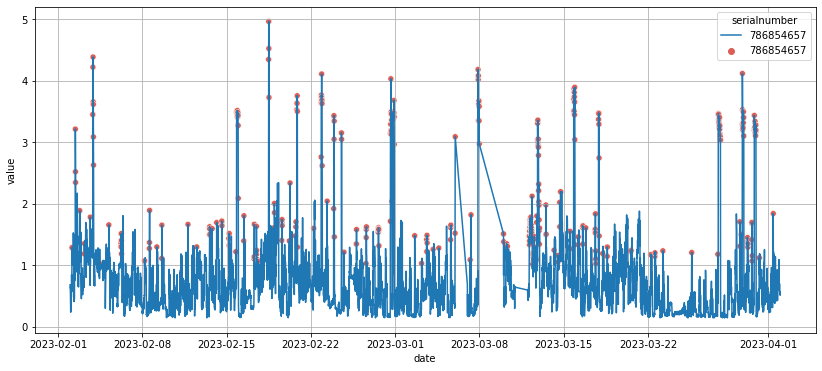

In [39]:
tmp_df = ami_df[ami_df['serialnumber']=='786854657'].sort_index().copy()

rtpd = thresholding_algo(
    y=tmp_df['value'].tolist(), 
    lag=12,
    threshold=4, 
    influence=0.0, 
    signal_abs_threshold=1.0
)
tmp_df['signals'] = rtpd['signals']
#-------------------------
fig, ax = Plot_General.default_subplots()
sns.lineplot(ax=ax, x='date', y='value', hue='serialnumber', data=tmp_df)
sns.scatterplot(ax=ax, x='date', y='value', hue='serialnumber', data=tmp_df[tmp_df['signals']==1], palette='hls')
ax.grid(True, which='both')

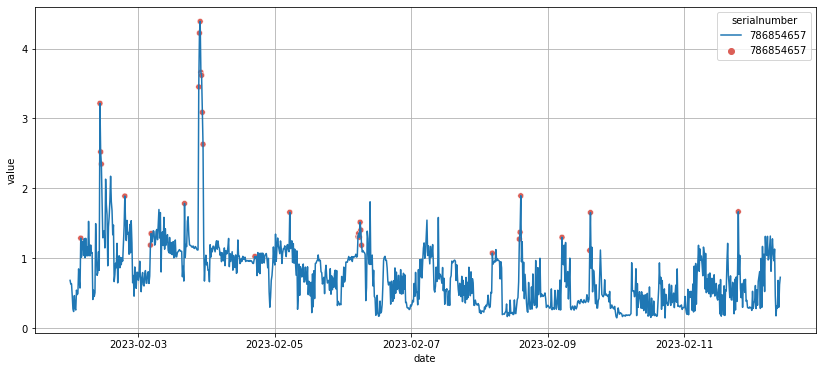

In [40]:
df1 = tmp_df[:1000].copy()
#-----
df2 = tmp_df[tmp_df['signals']==1].copy()
df2 = df2[df1.index.min():df1.index.max()]
#-------------------------
fig, ax = Plot_General.default_subplots()
sns.lineplot(ax=ax, x='date', y='value', hue='serialnumber', data=df1)
sns.scatterplot(ax=ax, x='date', y='value', hue='serialnumber', data=df2, palette='hls')
ax.grid(True, which='both')

In [ ]:
df_i = ami_df[ami_df['serialnumber']=='786854657'].sort_index().copy()
value_col = 'value'
lag=12
threshold=4
influence=0.0 
signal_abs_threshold=1.0
smooth_rolling_window=12
#-------------------------
df_i = thresholding_algo_df_i(
    df_i=df_i, 
    value_col=value_col, 
    lag=lag, 
    threshold=threshold, 
    influence=influence, 
    signal_abs_threshold=signal_abs_threshold, 
    smooth_rolling_window=smooth_rolling_window
)

In [ ]:
#-------------------------
fig, ax = Plot_General.default_subplots()
sns.lineplot(ax=ax, x='starttimeperiod_local', y='value', hue='serialnumber', data=df_i)
sns.scatterplot(ax=ax, x='starttimeperiod_local', y='value', hue='serialnumber', data=df_i[df_i['signal_binary']==1], palette='hls')
ax.grid(True, which='both')

In [ ]:
df1 = df_i[:1000].copy()
#-----
df2 = df_i[df_i['signal_binary']==1].copy()
df2 = df2[df1.index.min():df1.index.max()]
#-------------------------
fig, ax = Plot_General.default_subplots()
sns.lineplot(ax=ax, x='starttimeperiod_local', y='value', hue='serialnumber', data=df1)
sns.scatterplot(ax=ax, x='starttimeperiod_local', y='value', hue='serialnumber', data=df2, palette='hls')
ax.grid(True, which='both')

# PLOTS FOR ALL!!!!!

In [ ]:
# fig_num = 0

# df_evs = ami_df_resamples_evs['4H']
# df_non = ami_df_resamples_non['4H']
# #-----
# value_col = 'mean_TRS value'
# SN_col = 'serialnumber'
# time_col = 'date'
# #-----
# lag = 24
# threshold = 5
# influence = 0.0
# signal_abs_threshold=1.0
# #-----
# save_dir = r'C:\Users\s346557\Documents\LocalData\EVs\Figures\4H_L24_T5_ST1_reduced'

# # df_evs = ami_df_evs
# # df_non = ami_df_non
# # #-----
# # value_col = 'value'
# # SN_col = 'serialnumber'
# # time_col = 'date'
# # #-----
# # lag = 48
# # threshold = 5
# # influence = 0.0
# # signal_abs_threshold=1.0
# # #-----
# # save_dir = r'C:\Users\s346557\Documents\LocalData\EVs\Figures\15T_L48_T5_ST1'


# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# pdf = PdfPages(os.path.join(save_dir, 'EVs_w_signals.pdf'))
# for SN_i in df_evs[SN_col].unique().tolist():
#     df_i = df_evs[df_evs[SN_col]==SN_i].copy()
#     #-----
#     if df_i.shape[0]<=lag:
#         continue
#     #-----
#     # If there are a bunch of zero values at the beginning of df_i, this will throw off
#     #   the calculation.
#     # The following line gets ride of any leading zeros
#     df_i = df_i.iloc[df_i[value_col].ne(0).argmax():]
#     #-----
#     rtpd_i = thresholding_algo(
#         y=df_i[value_col].tolist(), 
#         lag=lag,
#         threshold=threshold, 
#         influence=influence, 
#         signal_abs_threshold=signal_abs_threshold
#     )
#     df_i['signals'] = rtpd_i['signals']
#     #-----
#     fig, ax = Plot_General.default_subplots(fig_num=fig_num)
#     sns.lineplot(ax=ax, x=time_col, y=value_col, data=df_i).set(title=f'SN = {SN_i}')
#     sns.scatterplot(ax=ax, x=time_col, y=value_col, data=df_i[df_i['signals']==1], color='red')
#     ax.axhline(y=signal_abs_threshold, color='red')
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.close(fig)
#     fig_num+=1
# pdf.close()
# #-------------------------
# pdf = PdfPages(os.path.join(save_dir, 'Non_w_signals.pdf'))
# for SN_i in df_non[SN_col].unique().tolist():
#     df_i = df_non[df_non[SN_col]==SN_i].copy()
#     #-----
#     if df_i.shape[0]<=lag:
#         continue
#     #-----
#     # If there are a bunch of zero values at the beginning of df_i, this will throw off
#     #   the calculation.
#     # The following line gets ride of any leading zeros
#     df_i = df_i.iloc[df_i[value_col].ne(0).argmax():]
#     #-----
#     rtpd_i = thresholding_algo(
#         y=df_i[value_col].tolist(), 
#         lag=lag,
#         threshold=threshold, 
#         influence=influence, 
#         signal_abs_threshold=signal_abs_threshold
#     )
#     df_i['signals'] = rtpd_i['signals']
#     #-----
#     fig, ax = Plot_General.default_subplots(fig_num=fig_num)
#     sns.lineplot(ax=ax, x=time_col, y=value_col, data=df_i).set(title=f'SN = {SN_i}')
#     sns.scatterplot(ax=ax, x=time_col, y=value_col, data=df_i[df_i['signals']==1], color='red')
#     ax.axhline(y=signal_abs_threshold, color='red')
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.close(fig)
#     fig_num+=1
# pdf.close()

In [ ]:
# fig_num = 0

# # df_evs = ami_df_resamples_evs['H'].reset_index()
# # df_non = ami_df_resamples_non['H'].reset_index()
# # #-----
# # value_col = 'mean_TRS value'
# # SN_col = 'serialnumber'
# # time_col = 'starttimeperiod_local'
# # #-----
# # lag=24
# # threshold=5
# # influence=0
# # signal_abs_threshold=1.0
# # smooth_rolling_window=12
# # #-----
# # save_dir = r'C:\Users\s346557\Documents\LocalData\EVs\Recent_Data\Figures\H_L24_T5_ST1_SRW12_reduced'

# df_evs = ami_df_evs
# df_non = ami_df_non
# #-----
# value_col = 'value'
# SN_col = 'serialnumber'
# time_col = 'starttimeperiod_local'
# #-----
# lag = 48
# threshold = 5
# influence = 0.0
# signal_abs_threshold=1.0
# smooth_rolling_window=24
# #-----
# save_dir = r'C:\Users\s346557\Documents\LocalData\EVs\Recent_Data\Figures\15T_L48_T5_ST1_SRW24_reduced'


# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# pdf = PdfPages(os.path.join(save_dir, 'EVs_w_signals.pdf'))
# for SN_i in df_evs[SN_col].unique().tolist():
#     df_i = df_evs[df_evs[SN_col]==SN_i].copy()
#     #-----
#     if df_i.shape[0]<=lag:
#         continue
#     #-----
#     # If there are a bunch of zero values at the beginning of df_i, this will throw off
#     #   the calculation.
#     # The following line gets ride of any leading zeros
# #     df_i = df_i.iloc[df_i[value_col].ne(0).argmax():]
#     #-----
#     df_i = thresholding_algo_df_i(
#         df_i=df_i, 
#         value_col=value_col, 
#         lag=lag, 
#         threshold=threshold, 
#         influence=influence, 
#         signal_abs_threshold=signal_abs_threshold, 
#         smooth_rolling_window=smooth_rolling_window
#     )
#     #-----
#     fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
#     df_i[value_col].plot(ax=ax, color='black')
#     df_i[df_i['signal_binary']==True].reset_index().plot.scatter(ax=ax, x='starttimeperiod_local', y=value_col, color='black')
#     df_i['test_final'].plot(ax=ax, color='red', linestyle='dotted')
#     df_i['test_final2'].plot(ax=ax, color='green', linestyle='dashed')
#     ax.axhline(y=signal_abs_threshold, color='red')
#     ax.set_title(f'SN = {SN_i}')
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.close(fig)
#     fig_num+=1
# pdf.close()
# #-------------------------
# pdf = PdfPages(os.path.join(save_dir, 'Non_w_signals.pdf'))
# for SN_i in df_non[SN_col].unique().tolist():
#     df_i = df_non[df_non[SN_col]==SN_i].copy()
#     #-----
#     if df_i.shape[0]<=lag:
#         continue
#     #-----
#     # If there are a bunch of zero values at the beginning of df_i, this will throw off
#     #   the calculation.
#     # The following line gets ride of any leading zeros
# #     df_i = df_i.iloc[df_i[value_col].ne(0).argmax():]
#     #-----
#     df_i = thresholding_algo_df_i(
#         df_i=df_i, 
#         value_col=value_col, 
#         lag=lag, 
#         threshold=threshold, 
#         influence=influence, 
#         signal_abs_threshold=signal_abs_threshold, 
#         smooth_rolling_window=smooth_rolling_window
#     )
#     #-----
#     fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
#     df_i[value_col].plot(ax=ax, color='black')
#     df_i[df_i['signal_binary']==True].reset_index().plot.scatter(ax=ax, x='starttimeperiod_local', y=value_col, color='black')
#     df_i['test_final'].plot(ax=ax, color='red', linestyle='dotted')
#     df_i['test_final2'].plot(ax=ax, color='green', linestyle='dashed')
#     ax.axhline(y=signal_abs_threshold, color='red')
#     pdf.savefig(fig, bbox_inches='tight')
#     ax.set_title(f'SN = {SN_i}')
#     plt.close(fig)
#     fig_num+=1
# pdf.close()

# OLD METHOD WITH PEAKS (15T)

In [ ]:
ami_df_evs_fit = ami_df_evs.drop(columns='starttimeperiod_local').copy()
ami_df_non_fit = ami_df_non.drop(columns='starttimeperiod_local').copy()
value_col = 'value'
lag=48
threshold=10
influence=0.0
signal_abs_threshold=2.0


In [ ]:
peak_df_evs = ami_df_evs_fit.groupby(['serialnumber']).apply(
    lambda x: extract_features_for_SN_v2(
        df_i=x, 
        lag=lag, 
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        value_col=value_col
    )
)
#-----
peak_df_non = ami_df_non_fit.groupby(['serialnumber']).apply(
    lambda x: extract_features_for_SN_v2(
        df_i=x, 
        lag=lag, 
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        value_col=value_col
    )
)
#-------------------------
peak_df_evs['target']=1
peak_df_non['target']=0
#-------------------------
peak_df=pd.concat([peak_df_evs, peak_df_non])
peak_df=peak_df.sample(frac=1)
#-------------------------
peak_df_OG = peak_df.copy()

In [ ]:
peak_df = peak_df_OG.copy()
#-------------------------
peak_df = fill_na_in_peak_df(peak_df)
peak_df = convert_to_seconds_in_peak_df(peak_df)
#-------------------------
peak_df_train, peak_df_test = train_test_split(peak_df, test_size=0.33, random_state=42)
#-------------------------
X_train = peak_df_train[[x for x in peak_df_train.columns.tolist() if x!='target']]
y_train = peak_df_train['target']
#-----
X_test = peak_df_test[[x for x in peak_df_test.columns.tolist() if x!='target']]
y_test = peak_df_test['target']
#-------------------------

In [ ]:
forest_clf = RandomForestClassifier(n_estimators = 10, max_depth=None, n_jobs=None)
start = time.time()
forest_clf.fit(X_train, y_train)
print(time.time()-start)

In [ ]:
y_pred_train = forest_clf.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))
print()

y_pred = forest_clf.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))
print()


In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
cmd = draw_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
fig_num += 1

In [ ]:
assert(len(peak_df.columns[:-1])==len(forest_clf.feature_importances_))
importances = list(zip(peak_df.columns[:-1], forest_clf.feature_importances_))
importances_srtd = sorted(importances, key=lambda x: x[1], reverse=True)
importances_srtd

In [ ]:
FUCKME

# OLD METHOD WITH PEAKS (H)

In [ ]:
ami_df_evs_fit = ami_df_resamples_evs['H'].copy()
ami_df_non_fit = ami_df_resamples_non['H'].copy()
value_col = 'mean_TRS value'
lag=24
threshold=5
influence=0.0
signal_abs_threshold=1.0

In [ ]:
peak_df_evs = ami_df_evs_fit.groupby(['serialnumber']).apply(
    lambda x: extract_features_for_SN_v2(
        df_i=x, 
        lag=lag, 
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        value_col=value_col
    )
)
#-----
peak_df_non = ami_df_non_fit.groupby(['serialnumber']).apply(
    lambda x: extract_features_for_SN_v2(
        df_i=x, 
        lag=lag, 
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        value_col=value_col
    )
)
#-------------------------
peak_df_evs['target']=1
peak_df_non['target']=0
#-------------------------
peak_df=pd.concat([peak_df_evs, peak_df_non])
peak_df=peak_df.sample(frac=1)
#-------------------------
peak_df_OG = peak_df.copy()

In [ ]:
peak_df = peak_df_OG.copy()
#-------------------------
peak_df = fill_na_in_peak_df(peak_df)
peak_df = convert_to_seconds_in_peak_df(peak_df)
#-------------------------
peak_df_train, peak_df_test = train_test_split(peak_df, test_size=0.33, random_state=42)
#-------------------------
X_train = peak_df_train[[x for x in peak_df_train.columns.tolist() if x!='target']]
y_train = peak_df_train['target']
#-----
X_test = peak_df_test[[x for x in peak_df_test.columns.tolist() if x!='target']]
y_test = peak_df_test['target']
#-------------------------

In [ ]:
forest_clf = RandomForestClassifier(n_estimators = 10, max_depth=None, n_jobs=None)
start = time.time()
forest_clf.fit(X_train, y_train)
print(time.time()-start)

In [ ]:
#-------------------------
y_pred_train = forest_clf.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))
print()

y_pred = forest_clf.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))
print()

In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
cmd = draw_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
fig_num += 1

# GRID SEARCH

In [ ]:
# # lags = [8, 12, 24, 48, 96, 192]
# # thresholds = [2, 5, 8, 10, 15]
# # signal_abs_thresholds = [0, 1, 1.5, 2, 2.5]

# lags = [8, 12, 24, 48, 96, 192]
# thresholds = [2, 5, 8, 10, 15]
# signal_abs_thresholds = [0, 1, 2]

# for lag in lags:
#     for threshold in thresholds:
#         for signal_abs_threshold in signal_abs_thresholds:
#             peak_df_evs = ami_df_evs.drop(columns='starttimeperiod_local').groupby(['serialnumber']).apply(
#                 lambda x: extract_features_for_SN(
#                     df_i=x, 
#                     lag=lag, 
#                     threshold=threshold, 
#                     influence=0.0, 
#                     signal_abs_threshold=signal_abs_threshold, 
#                     value_col='value'
#                 )
#             )
#             #-----
#             peak_df_non = ami_df_non.drop(columns='starttimeperiod_local').groupby(['serialnumber']).apply(
#                 lambda x: extract_features_for_SN(
#                     df_i=x, 
#                     lag=lag, 
#                     threshold=threshold, 
#                     influence=0.0, 
#                     signal_abs_threshold=signal_abs_threshold, 
#                     value_col='value'
#                 )
#             )
#             #-------------------------
#             peak_df_evs['target']=1
#             peak_df_non['target']=0
#             #-----
#             peak_df=pd.concat([peak_df_evs, peak_df_non])
#             peak_df=peak_df.sample(frac=1)
#             #-------------------------            
#             peak_df = fill_na_in_peak_df(peak_df)
#             peak_df = convert_to_seconds_in_peak_df(peak_df)
#             #-------------------------
#             peak_df_train, peak_df_test = train_test_split(peak_df, test_size=0.33, random_state=42)
#             #-----
#             X_train = peak_df_train[[x for x in peak_df_train.columns.tolist() if x!='target']]
#             y_train = peak_df_train['target']
#             #-----
#             X_test = peak_df_test[[x for x in peak_df_test.columns.tolist() if x!='target']]
#             y_test = peak_df_test['target']
#             #-------------------------
#             forest_clf = RandomForestClassifier(n_estimators = 10, max_depth=None, n_jobs=None)
#             start = time.time()
#             forest_clf.fit(X_train, y_train)
#             print(time.time()-start)
#             #-------------------------
#             print('\n\n')
#             print(f'lag                  = {lag}')
#             print(f'threshold            = {threshold}')
#             print(f'signal_abs_threshold = {signal_abs_threshold}')
#             #-------------------------
#             y_pred_train = forest_clf.predict(X_train)
#             print('*****'*5)
#             print('TRAINING DATASET')
#             print('*****'*5)
#             print(f"#(target==1): {y_train.sum()}")
#             print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
#             print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
#             print('-----'*5)
#             print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
#             print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
#             print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
#             print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))
#             print()

#             y_pred = forest_clf.predict(X_test)
#             print('*****'*5)
#             print('TESTING DATASET')
#             print('*****'*5)
#             print(f"#(target==1): {y_test.sum()}")
#             print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
#             print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
#             print('-----'*5)
#             print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
#             print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
#             print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
#             print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))
#             print()


# peak_df scatterplots

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(
    peak_df['peak_max_mean'].tolist(), 
    peak_df['peak_width_mean'].tolist(), 
    peak_df['peak_spacing_mean'].tolist(), 
    color='red'
)

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    peak_df[peak_df['target']==1]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==1]['peak_width_mean'].tolist(), 
    peak_df[peak_df['target']==1]['peak_spacing_mean'].tolist(), 
    color='red'
)
# ax.scatter(
#     peak_df[peak_df['target']==0]['peak_max_mean'].tolist(), 
#     peak_df[peak_df['target']==0]['peak_width_mean'].tolist(), 
#     peak_df[peak_df['target']==0]['peak_spacing_mean'].tolist(), 
#     color='blue'
# )

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(projection='3d')
# ax.scatter(
#     peak_df[peak_df['target']==1]['peak_max_mean'].tolist(), 
#     peak_df[peak_df['target']==1]['peak_width_mean'].tolist(), 
#     peak_df[peak_df['target']==1]['peak_spacing_mean'].tolist(), 
#     color='red'
# )
ax.scatter(
    peak_df[peak_df['target']==0]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==0]['peak_width_mean'].tolist(), 
    peak_df[peak_df['target']==0]['peak_spacing_mean'].tolist(), 
    color='blue'
)

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    peak_df[peak_df['target']==1]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==1]['peak_width_mean'].tolist(), 
    peak_df[peak_df['target']==1]['peak_spacing_mean'].tolist(), 
    color='red'
)
ax.scatter(
    peak_df[peak_df['target']==0]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==0]['peak_width_mean'].tolist(), 
    peak_df[peak_df['target']==0]['peak_spacing_mean'].tolist(), 
    color='blue'
)

ax.set_xlabel('peak_max_mean', fontweight ='bold')
ax.set_ylabel('peak_width_mean', fontweight ='bold')
ax.set_zlabel('peak_spacing_mean', fontweight ='bold')

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot()
ax.scatter(
    peak_df[peak_df['target']==1]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==1]['peak_width_mean'].tolist(), 
    color='red'
)
ax.scatter(
    peak_df[peak_df['target']==0]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==0]['peak_width_mean'].tolist(), 
    color='blue'
)

ax.set_xlabel('peak_max_mean', fontweight ='bold')
ax.set_ylabel('peak_width_mean', fontweight ='bold')
plt.show()

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot()
ax.scatter(
    peak_df[peak_df['target']==0]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==0]['peak_width_mean'].tolist(), 
    color='blue'
)

ax.set_xlabel('peak_max_mean', fontweight ='bold')
ax.set_ylabel('peak_width_mean', fontweight ='bold')
plt.show()

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot()
ax.scatter(
    peak_df[peak_df['target']==1]['peak_max_mean'].tolist(), 
    peak_df[peak_df['target']==1]['peak_width_mean'].tolist(), 
    color='red'
)

ax.set_xlabel('peak_max_mean', fontweight ='bold')
ax.set_ylabel('peak_width_mean', fontweight ='bold')
plt.show()

In [ ]:
peak_df

In [ ]:
peak_df

# OLD METHOD WITH KERAS

In [ ]:
ami_df_evs_fit = ami_df_resamples_evs['H'].copy()
ami_df_non_fit = ami_df_resamples_non['H'].copy()
value_col = 'mean_TRS value'
n_entries=200

# ami_df_evs_fit = ami_df_evs.drop(columns='starttimeperiod_local').copy()
# ami_df_non_fit = ami_df_non.drop(columns='starttimeperiod_local').copy()
# value_col = 'value'
# n_entries=500


In [ ]:
keras_df_evs = ami_df_evs_fit.groupby(['serialnumber']).apply(
    lambda x: make_it_funky(
        df_i=x, 
        n_entries=n_entries, 
        val_col=value_col, 
        SN_col='serialnumber'
    )
)
#-----
keras_df_non = ami_df_non_fit.groupby(['serialnumber']).apply(
    lambda x: make_it_funky(
        df_i=x, 
        n_entries=n_entries, 
        val_col=value_col, 
        SN_col='serialnumber'
    )
)
#-------------------------
keras_df_evs['target']=1
keras_df_non['target']=0
#-------------------------
keras_df = pd.concat([keras_df_evs, keras_df_non])
#-------------------------
keras_df=keras_df.dropna()
#-------------------------
keras_df_train, keras_df_test = train_test_split(keras_df, test_size=0.33, random_state=42)
#-------------------------
X_train = keras_df_train[[x for x in keras_df_train.columns.tolist() if x != 'target']].values
y_train = keras_df_train['target'].values
X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#-----
X_test = keras_df_test[[x for x in keras_df_test.columns.tolist() if x != 'target']].values
y_test = keras_df_test['target'].values
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#-------------------------

In [ ]:
# def make_model(input_shape):
#     num_classes=2
#     input_layer = keras.layers.Input(input_shape)

#     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

#     gap = keras.layers.GlobalAveragePooling1D()(conv3)

#     output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

#     return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
def make_model(input_shape):
    num_classes=2
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=5, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=10, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    conv4 = keras.layers.Conv1D(filters=64, kernel_size=10, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)

    gap = keras.layers.GlobalAveragePooling1D()(conv4)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# epochs = 500
epochs = 50
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Train accuracy", train_acc)
print("Train loss", train_loss)

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
#-----
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
#-----
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))

In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
cmd = draw_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
fig_num += 1

# NEW METHOD PLOTS

In [ ]:
df_i = ami_df_resamples_evs['H'][ami_df_resamples_evs['H']['serialnumber']=='786854657'].sort_index().copy()
value_col = 'mean_TRS value'

# df_i = ami_df_evs[ami_df_evs['serialnumber']=='786854657'].sort_index().copy()
# value_col = 'value'

# df_i = ami_df_non[ami_df_non['serialnumber']=='780852455'].sort_index().iloc[:1000].copy()
# value_col = 'value'

# df_i = ami_df_resamples_non['H'][ami_df_resamples_non['H']['serialnumber']=='780852455'].sort_index().copy()
# value_col = 'mean_TRS value'

df_i_OG = df_i.copy()

lag=24
threshold=5
influence=0
signal_abs_threshold=1.0
smooth_rolling_window=12

smooth_col = f'{value_col}_smooth'
smooth_roll_mean_col = f'{value_col}_smooth_roll_mean'
smooth_roll_std_col  = f'{value_col}_smooth_roll_std'

signal_col_out='signal'
signal_pos_col_out='signal_pos'
signal_binary_col_out='signal_binary'
signal_pos_binary_col_out='signal_pos_binary'

In [ ]:
df_i = thresholding_algo_df_i(
    df_i=df_i, 
    value_col=value_col, 
    lag=lag, 
    threshold=threshold, 
    influence=influence, 
    signal_abs_threshold=signal_abs_threshold, 
    smooth_rolling_window=smooth_rolling_window
)

In [ ]:
df_i

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=2)

df_i[value_col].plot(ax=axs[0], color='blue')
df_i[smooth_col].plot(ax=axs[0], color='green')
df_i[smooth_roll_mean_col].plot(ax=axs[0], color='red')

df_i[signal_col_out].plot(ax=axs[1], color='blue')
df_i[signal_pos_col_out].plot(ax=axs[1], color='green')
df_i[df_i[signal_binary_col_out]==1].reset_index().plot.scatter(ax=axs[1], x='starttimeperiod_local', y=signal_col_out, color='blue', alpha=0.5)
df_i[df_i[signal_pos_binary_col_out]==1].reset_index().plot.scatter(ax=axs[1], x='starttimeperiod_local', y=signal_pos_col_out, color='green', alpha=0.5)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=2)

df_i[value_col].plot(ax=axs[0], color='blue')
df_i['test_final'].plot(ax=axs[0], color='purple')

df_i[signal_col_out].plot(ax=axs[1], color='blue')
df_i['test_final_signal'].plot(ax=axs[1], color='purple')

# NEW METHOD

In [ ]:
ami_df_evs_fit = ami_df_resamples_evs['H'].copy()
ami_df_non_fit = ami_df_resamples_non['H'].copy()
#-----
value_col = 'mean_TRS value'
# lag=12
# threshold=5
# influence=0
# signal_abs_threshold=0.5
# smooth_rolling_window=12

# lag                   = 24
# threshold             = 3
# influence             = 0 
# signal_abs_threshold  = 1.0
# smooth_rolling_window = 24

lag                   = 24
threshold             = 2
influence             = 0 
signal_abs_threshold  = 1.0
smooth_rolling_window = 48

# lag                   = 48
# threshold             = 2
# influence             = 0 
# signal_abs_threshold  = 2.0
# smooth_rolling_window = 36

funky_n_entries=200
# fit_signal_col_keras='test_final'
fit_signal_col_keras='test_final2'

# fit_signal_col_peaks = 'test_final'
fit_signal_col_peaks = 'signal'


# ami_df_evs_fit = ami_df_evs.copy()
# ami_df_non_fit = ami_df_non.copy()
# #-----
# value_col = 'value'
# lag=48
# threshold=5
# influence=0
# signal_abs_threshold=1.0
# smooth_rolling_window=48
# funky_n_entries=500
# fit_signal_col_keras='test_final'

# # fit_signal_col_peaks = 'test_final'
# fit_signal_col_peaks = 'signal'



signal_col_out='signal'
signal_pos_col_out='signal_pos'
signal_binary_col_out='signal_binary'
signal_pos_binary_col_out='signal_pos_binary'

In [ ]:
#-------------------------
ami_df_evs_fit = ami_df_evs_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
    lambda x: thresholding_algo_df_i(
        df_i=x, 
        value_col=value_col, 
        lag=lag, 
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        smooth_rolling_window=smooth_rolling_window
    )
)
ami_df_non_fit = ami_df_non_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
    lambda x: thresholding_algo_df_i(
        df_i=x, 
        value_col=value_col, 
        lag=lag, 
        threshold=threshold, 
        influence=influence, 
        signal_abs_threshold=signal_abs_threshold, 
        smooth_rolling_window=smooth_rolling_window
    )
)


In [ ]:
ami_df_evs_fit

## NEW METHOD KERAS

In [ ]:
fit_signal_col_keras='test_final'
# fit_signal_col_keras=value_col

In [ ]:
#----------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------
keras_df_evs = ami_df_evs_fit.reset_index(drop=True).groupby(['serialnumber']).apply(
    lambda x: make_it_funky(
        df_i=x, 
        n_entries=funky_n_entries, 
        val_col=fit_signal_col_keras, 
        SN_col='serialnumber'
    )
)
keras_df_non = ami_df_non_fit.reset_index(drop=True).groupby(['serialnumber']).apply(
    lambda x: make_it_funky(
        df_i=x, 
        n_entries=funky_n_entries, 
        val_col=fit_signal_col_keras, 
        SN_col='serialnumber'
    )
)

In [ ]:


#-------------------------
keras_df_evs['target']=1
keras_df_non['target']=0
keras_df = pd.concat([keras_df_evs, keras_df_non])
keras_df=keras_df.dropna()
#-------------------------
keras_df_train, keras_df_test = train_test_split(keras_df, test_size=0.33, random_state=42)
#-------------------------
X_train = keras_df_train[[x for x in keras_df_train.columns.tolist() if x != 'target']].values
y_train = keras_df_train['target'].values
X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#-----
X_test = keras_df_test[[x for x in keras_df_test.columns.tolist() if x != 'target']].values
y_test = keras_df_test['target'].values
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
def make_model(input_shape):
    num_classes=2
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=16, kernel_size=25, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=8, kernel_size=10, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    conv4 = keras.layers.Conv1D(filters=4, kernel_size=10, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)

    gap = keras.layers.GlobalAveragePooling1D()(conv4)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
def make_model(input_shape):
    num_classes=2
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=16, kernel_size=25, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=8, kernel_size=25, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    conv4 = keras.layers.Conv1D(filters=4, kernel_size=50, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)
    
    conv5 = keras.layers.Conv1D(filters=4, kernel_size=20, padding="same")(conv4)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.ReLU()(conv5)

    gap = keras.layers.GlobalAveragePooling1D()(conv5)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# epochs = 500
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        r'C:\Users\s346557\Downloads\tmp1\best_model.h5', save_best_only=True, monitor="val_loss"
    ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
model = keras.models.load_model(r'C:\Users\s346557\Downloads\tmp1\best_model.h5')

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Train accuracy", train_acc)
print("Train loss", train_loss)

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
#-----
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
#-----
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))

In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
cmd = draw_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
fig_num += 1

In [ ]:
# save_name = f"keras_cmd_L{lag}_T{threshold}_ST{str(signal_abs_threshold).replace('.', '_')}_SRW{smooth_rolling_window}.png"
# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=r'C:\Users\s346557\Documents\Presentations\EVs\Figures', 
#     save_name=save_name, 
#     bbox_inches='tight'
# )

In [ ]:
assert(keras_df_test.shape[0]==len(y_pred))
keras_df_test_w_preds = keras_df_test.copy()
keras_df_test_w_preds['y_pred'] = y_pred

In [ ]:
keras_df_test_w_preds[
    (keras_df_test_w_preds['target']==1) & 
    (keras_df_test_w_preds['y_pred']==0)
]

In [ ]:
keras_df_test_w_preds[
    (keras_df_test_w_preds['target']==1) & 
    (keras_df_test_w_preds['y_pred']==0)
].index.tolist()

In [ ]:
df_i = ami_df_evs_fit[ami_df_evs_fit['serialnumber']=='996575104'].copy()
value_col = 'mean_TRS value'

# lag=24
# threshold=5
# influence=0
# signal_abs_threshold=1.0
# smooth_rolling_window=12

lag=24
threshold=3
influence=0
signal_abs_threshold=0.0
smooth_rolling_window=48

In [ ]:
df_i = thresholding_algo_df_i(
    df_i=df_i, 
    value_col=value_col, 
    lag=lag, 
    threshold=threshold, 
    influence=influence, 
    signal_abs_threshold=signal_abs_threshold, 
    smooth_rolling_window=smooth_rolling_window
)

In [ ]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
df_i[value_col].plot(ax=ax, color='black')
df_i[df_i['signal_binary']==True].reset_index().plot.scatter(ax=ax, x='starttimeperiod_local', y=value_col, color='black')
df_i['test_final'].plot(ax=ax, color='red', linestyle='dotted')
df_i['test_final2'].plot(ax=ax, color='green', linestyle='dashed')
ax.axhline(y=signal_abs_threshold, color='red')

In [ ]:
keras_df_test_w_preds[
    (keras_df_test_w_preds['target']==0) & 
    (keras_df_test_w_preds['y_pred']==1)
]

In [ ]:
df_i = ami_df_non_fit[ami_df_non_fit['serialnumber']=='766690041'].copy()
value_col = 'mean_TRS value'

# lag=24
# threshold=5
# influence=0
# signal_abs_threshold=1.0
# smooth_rolling_window=12

lag=24
threshold=5
influence=0
signal_abs_threshold=1.0
smooth_rolling_window=48

In [ ]:
df_i = thresholding_algo_df_i(
    df_i=df_i, 
    value_col=value_col, 
    lag=lag, 
    threshold=threshold, 
    influence=influence, 
    signal_abs_threshold=signal_abs_threshold, 
    smooth_rolling_window=smooth_rolling_window
)

In [ ]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
df_i[value_col].plot(ax=ax, color='black')
df_i[df_i['signal_binary']==True].reset_index().plot.scatter(ax=ax, x='starttimeperiod_local', y=value_col, color='black')
df_i['test_final'].plot(ax=ax, color='red', linestyle='dotted')
df_i['test_final2'].plot(ax=ax, color='green', linestyle='dashed')
ax.axhline(y=signal_abs_threshold, color='red')

In [ ]:
keras_df_test_w_preds[keras_df_test_w_preds['target']==0].describe()

In [ ]:
keras_df_test_w_preds[keras_df_test_w_preds['target']==1].describe()

In [ ]:
keras_df_test_w_preds[
    (keras_df_test_w_preds['target']==0) & 
    (keras_df_test_w_preds['y_pred']==0)
].describe()

In [ ]:
keras_df_test_w_preds[
    (keras_df_test_w_preds['target']==0) & 
    (keras_df_test_w_preds['y_pred']==1)
].describe()

In [ ]:
keras_df_test_w_preds[
    (keras_df_test_w_preds['target']==1) & 
    (keras_df_test_w_preds['y_pred']==1)
].describe()

In [ ]:
keras_df_test_w_preds[
    (keras_df_test_w_preds['target']==1) & 
    (keras_df_test_w_preds['y_pred']==0)
]

In [ ]:
# df_i = ami_df_resamples_evs['H'][ami_df_resamples_evs['H']['serialnumber']=='786854657'].sort_index().copy()
# value_col = 'mean_TRS value'

df_i = ami_df_evs[ami_df_evs['serialnumber']=='761789064'].sort_index().copy()
value_col = 'value'

# df_i = ami_df_non[ami_df_non['serialnumber']=='780852455'].sort_index().iloc[:1000].copy()
# value_col = 'value'

# df_i = ami_df_resamples_non['H'][ami_df_resamples_non['H']['serialnumber']=='780852455'].sort_index().copy()
# value_col = 'mean_TRS value'


lag=24
threshold=5
influence=0
signal_abs_threshold=1.0
smooth_rolling_window=12

smooth_col = f'{value_col}_smooth'
smooth_roll_mean_col = f'{value_col}_smooth_roll_mean'
smooth_roll_std_col  = f'{value_col}_smooth_roll_std'

signal_col_out='signal'
signal_pos_col_out='signal_pos'
signal_binary_col_out='signal_binary'
signal_pos_binary_col_out='signal_pos_binary'

In [ ]:
df_i = thresholding_algo_df_i(
    df_i=df_i, 
    value_col=value_col, 
    lag=lag, 
    threshold=threshold, 
    influence=influence, 
    signal_abs_threshold=signal_abs_threshold, 
    smooth_rolling_window=smooth_rolling_window
)

In [ ]:
df_i.head(20)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=2)

df_i[value_col].plot(ax=axs[0], color='blue')
df_i[smooth_col].plot(ax=axs[0], color='green')
df_i[smooth_roll_mean_col].plot(ax=axs[0], color='red')

df_i[signal_col_out].plot(ax=axs[1], color='blue')
df_i[signal_pos_col_out].plot(ax=axs[1], color='green')
df_i[df_i[signal_binary_col_out]==1].reset_index().plot.scatter(ax=axs[1], x='starttimeperiod_local', y=signal_col_out, color='blue', alpha=0.5)
df_i[df_i[signal_pos_binary_col_out]==1].reset_index().plot.scatter(ax=axs[1], x='starttimeperiod_local', y=signal_pos_col_out, color='green', alpha=0.5)

In [ ]:
fig, axs = Plot_General.default_subplots(n_x=1, n_y=2)

df_i[value_col].plot(ax=axs[0], color='blue')
df_i['test_final'].plot(ax=axs[0], color='purple')

df_i[signal_col_out].plot(ax=axs[1], color='blue')
df_i['test_final_signal'].plot(ax=axs[1], color='purple')

In [ ]:
df_i

In [ ]:
ami_df_evs_fit

In [ ]:
df_i = ami_df_evs_fit[ami_df_evs_fit['serialnumber']=='786854657'].copy()
signal_group_col='signal_grp'
signal_col='signal_binary'

In [ ]:
df_i.shape

In [ ]:
return_signal_group_col='signal_grp'

In [ ]:
df_i = set_signal_groups_in_df_i(
    df_i=df_i, 
    SN_col='serialnumber',
    signal_col=signal_col, 
    return_signal_group_col=return_signal_group_col
)

In [ ]:
df_i.shape

In [ ]:
df_i

In [ ]:
dev_features_df_i = build_peak_features_for_df_i(
    df_i, 
    signal_group_col='signal_grp', 
    value_col='mean_TRS value', 
    SN_col='serialnumber', 
    time_col='starttimeperiod_local', 
)

In [ ]:
dev_features_df_i

In [ ]:
df_i2 = ami_df_evs[ami_df_evs['serialnumber']=='786854657'].drop(columns=['starttimeperiod_local'])
dev_features_df_i2 = extract_features_for_SN_v2(
    df_i=df_i2, 
    lag=24, 
    threshold=5,
    influence=0, 
    signal_abs_threshold=1.0, 
    value_col='value', 
    SN_col='serialnumber', 
    time_col='starttimeperiod_local', 
    signal_col='signals'
)

In [ ]:
dev_features_df_i2

## NEW METHOD PEAKS

In [ ]:
peak_df_evs = ami_df_evs_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
    lambda x: set_signal_groups_in_df_i(
        df_i=x, 
        SN_col='serialnumber',
        signal_col='signal_binary', 
        return_signal_group_col='signal_grp'        
    )
)
#-----
peak_df_non = ami_df_non_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
    lambda x: set_signal_groups_in_df_i(
        df_i=x, 
        SN_col='serialnumber',
        signal_col='signal_binary', 
        return_signal_group_col='signal_grp'        
    )
)
#-------------------------
peak_df_evs = peak_df_evs.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
    lambda x: build_peak_features_for_df_i(
        df_i=x, 
        signal_group_col='signal_grp', 
        value_col=fit_signal_col_peaks,
        SN_col='serialnumber', 
        time_col='starttimeperiod_local',        
    )
)
#-----
peak_df_non = peak_df_non.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
    lambda x: build_peak_features_for_df_i(
        df_i=x, 
        signal_group_col='signal_grp', 
        value_col=fit_signal_col_peaks, 
        SN_col='serialnumber', 
        time_col='starttimeperiod_local',        
    )
)
#-------------------------
peak_df_evs['target']=1
peak_df_non['target']=0
#-------------------------
peak_df=pd.concat([peak_df_evs, peak_df_non])
peak_df=peak_df.sample(frac=1)
#-------------------------
peak_df_OG = peak_df.copy()
#-------------------------

In [ ]:
peak_df = peak_df_OG.copy()
#-------------------------
peak_df = fill_na_in_peak_df(peak_df)
peak_df = convert_to_seconds_in_peak_df(peak_df)
peak_df = peak_df.drop(columns=['serialnumber'])
#-------------------------
# peak_df = peak_df.drop(columns=[
#     'peak_mean', 'peak_std', 
#     'peak_max_std', 
#     'peak_width_std', 
#     'peak_spacing_std'
# ])
#-------------------------
# Remove inf values
print(f"Before inf removal, peak_df.shape[0] = {peak_df.shape[0]}")
peak_df = peak_df.loc[np.isinf(peak_df[[x for x in peak_df.columns if x!='serialnumber']]).sum(axis=1)==0].copy()
print(f"After inf removal, peak_df.shape[0] = {peak_df.shape[0]}")
#-------------------------
peak_df_train, peak_df_test = train_test_split(peak_df, test_size=0.33, random_state=42)
#-------------------------
X_train = peak_df_train[[x for x in peak_df_train.columns.tolist() if x!='target']]
y_train = peak_df_train['target']
#-----
X_test = peak_df_test[[x for x in peak_df_test.columns.tolist() if x!='target']]
y_test = peak_df_test['target']
#-------------------------

### Random Forest

In [ ]:
# forest_clf = RandomForestClassifier(n_estimators = 10, max_depth=None, n_jobs=None)
# forest_clf = RandomForestClassifier(
#     n_estimators = 100, 
#     criterion='log_loss', 
#     max_depth=40,
#     max_features='log2', 
#     bootstrap=True, 
#     n_jobs=None
# )
forest_clf = RandomForestClassifier(
    n_estimators = 10, 
    criterion='log_loss', 
    max_depth=40,
    max_features='log2', 
    bootstrap=True, 
    n_jobs=None
)

start = time.time()
forest_clf.fit(X_train, y_train)
print(time.time()-start)

In [ ]:
y_pred_train = forest_clf.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))
print()

y_pred = forest_clf.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))
print()


In [ ]:
cross_val_score(forest_clf, X_train, y_train, cv=10, scoring='accuracy').mean()

In [ ]:
cross_val_score(forest_clf, X_train, y_train, cv=10, scoring='precision').mean()

In [ ]:
cross_val_score(forest_clf, X_train, y_train, cv=10, scoring='recall').mean()

In [ ]:
cross_val_score(forest_clf, X_train, y_train, cv=10, scoring='f1').mean()

In [ ]:
res = cross_validate(forest_clf, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'])
res

In [ ]:
print(f"accuracy:  {res['test_accuracy'].mean()}")
print(f"precision: {res['test_precision'].mean()}")
print(f"recall:    {res['test_recall'].mean()}")
print(f"f1:        {res['test_f1'].mean()}")

In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
cmd = draw_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
fig_num += 1

In [ ]:
# save_name = f"forest_L{lag}_T{threshold}_ST{str(signal_abs_threshold).replace('.', '_')}_SRW{smooth_rolling_window}.png"
# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=r'C:\Users\s346557\Documents\Presentations\EVs\Figures', 
#     save_name=save_name, 
#     bbox_inches='tight'
# )

In [ ]:
assert(len(peak_df.columns[:-1])==len(forest_clf.feature_importances_))
importances = list(zip(peak_df.columns[:-1], forest_clf.feature_importances_))
importances_srtd = sorted(importances, key=lambda x: x[1], reverse=True)

In [ ]:
importances_srtd

In [ ]:
forest_param_grid = { 
    'n_estimators': [100, 200, 500, 1000, 2000],
    'max_features': ['sqrt', 'log2', None],
    'max_depth' : [10, 20, 30, 40, 50],
    'criterion' :['gini', 'entropy', 'log_loss'], 
    'bootstrap':[True,False]
}


In [ ]:
forest_grid_search = GridSearchCV(
    forest_clf, forest_param_grid, cv=3, 
    scoring=None, 
    return_train_score=True
)

In [ ]:
start = time.time()
forest_grid_search.fit(X_train, y_train)
print(time.time()-start)

print(forest_grid_search.best_params_)
print(forest_grid_search.best_estimator_)
y_pred = forest_grid_search.best_estimator_.predict(X_test)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

### SVC

In [ ]:
X_train

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
X_train

In [ ]:
#Create a svm Classifier
clf = svm.SVC()

#Train the model using the training sets
clf.fit(X_train, y_train)

In [ ]:
y_pred_train = clf.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))
print()

y_pred = clf.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))
print()


In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
cmd = draw_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
fig_num += 1

In [ ]:
# save_name = f"svc_L{lag}_T{threshold}_ST{str(signal_abs_threshold).replace('.', '_')}_SRW{smooth_rolling_window}.png"
# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=r'C:\Users\s346557\Documents\Presentations\EVs\Figures', 
#     save_name=save_name, 
#     bbox_inches='tight'
# )

In [ ]:
clf = svm.SVC()

# # NOTE: Can be a single dict, or a list of dicts
svc_param_grid = { 
    'C': [0.000001, 0.001, 0.1, 0, 1.0, 10, 100], 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 5, 7, 9, 12], # Only for poly!
    'gamma':['scale', 'auto'] # Only for rbf, poly, and sigmoid!
}

In [ ]:
svc_grid_search = GridSearchCV(
    clf, svc_param_grid, cv=3, 
    scoring=None, 
    return_train_score=True
)

In [ ]:
start = time.time()
svc_grid_search.fit(X_train, y_train)
print(time.time()-start)

print(svc_grid_search.best_params_)
print(svc_grid_search.best_estimator_)
y_pred = svc_grid_search.best_estimator_.predict(X_test)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=0.1)

# fit the model with data
logreg.fit(X_train, y_train)

In [ ]:
y_pred_train = logreg.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print("F1        OF THE MODEL: ", f1_score(y_train, y_pred_train))
print()

y_pred = logreg.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print("F1        OF THE MODEL: ", f1_score(y_test, y_pred))
print()


In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
cmd = draw_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    text_kw=dict(fontsize='xx-large'), 
    target_eq_1_name='EV', 
    target_eq_0_name='Not EV'
)
#-----
fig_num += 1

In [ ]:
# save_name = f"logreg_L{lag}_T{threshold}_ST{str(signal_abs_threshold).replace('.', '_')}_SRW{smooth_rolling_window}.png"
# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=r'C:\Users\s346557\Documents\Presentations\EVs\Figures', 
#     save_name=save_name, 
#     bbox_inches='tight'
# )

In [ ]:
logreg = LogisticRegression()

# # NOTE: Can be a single dict, or a list of dicts
logreg_param_grid = { 
    'C': [0.000001, 0.001, 0.1, 0, 1.0, 10, 100, 10000], 
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'dual': [True, False], 
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [ ]:
logreg_grid_search = GridSearchCV(
    logreg, logreg_param_grid, cv=3, 
    scoring=None, 
    return_train_score=True
)

In [ ]:
start = time.time()
logreg_grid_search.fit(X_train, y_train)
print(time.time()-start)

print(logreg_grid_search.best_params_)
print(logreg_grid_search.best_estimator_)
y_pred = logreg_grid_search.best_estimator_.predict(X_test)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

# GRID SEARCH

In [ ]:
def make_model(input_shape):
    num_classes=2
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=16, kernel_size=25, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=8, kernel_size=10, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    conv4 = keras.layers.Conv1D(filters=4, kernel_size=10, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)

    gap = keras.layers.GlobalAveragePooling1D()(conv4)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
grid_results_df_empty = pd.DataFrame(columns=[
    'lag', 
    'threshold', 
    'signal_abs_threshold', 
    'smooth_rolling_window', 
    #-----
    'acc_train_keras', 
    'prec_train_keras', 
    'rec_train_keras', 
    'f1_train_keras', 
    
    'acc_test_keras', 
    'prec_test_keras', 
    'rec_test_keras', 
    'f1_test_keras', 
    #-----
    'acc_train_forest', 
    'prec_train_forest', 
    'rec_train_forest', 
    'f1_train_forest', 
    
    'acc_test_forest', 
    'prec_test_forest', 
    'rec_test_forest', 
    'f1_test_forest', 
    #-----
    'acc_train_svc', 
    'prec_train_svc', 
    'rec_train_svc', 
    'f1_train_svc', 
    
    'acc_test_svc', 
    'prec_test_svc', 
    'rec_test_svc', 
    'f1_test_svc', 
    #-----
    'acc_train_logreg', 
    'prec_train_logreg', 
    'rec_train_logreg', 
    'f1_train_logreg', 
    
    'acc_test_logreg', 
    'prec_test_logreg', 
    'rec_test_logreg', 
    'f1_test_logreg'    
])

In [ ]:
ami_df_evs_fit = ami_df_resamples_evs['H'].copy()
ami_df_non_fit = ami_df_resamples_non['H'].copy()
#-----
value_col = 'mean_TRS value'
funky_n_entries=200

fit_signal_col_keras='test_final'
# fit_signal_col_keras='test_final2'

fit_signal_col_peaks = 'test_final'
# fit_signal_col_peaks = 'signal'

In [ ]:
lags = [24, 36, 48]
thresholds = [2, 3, 5, 10]
signal_abs_thresholds = [0, 1, 2]
smooth_rolling_windows = [24, 36, 48]

# lags = [24, 48]
# thresholds = [3]
# signal_abs_thresholds = [1]
# smooth_rolling_windows = [24]

In [ ]:
grid_lists = [
    lags, 
    thresholds, 
    signal_abs_thresholds, 
    smooth_rolling_windows
]

In [ ]:
start=time.time()
grid_results_df = grid_results_df_empty.copy()
for i, grid_i in enumerate(list(itertools.product(*grid_lists))):
    start_i = time.time()
    lag                   = grid_i[0]
    threshold             = grid_i[1]
    signal_abs_threshold  = grid_i[2]
    smooth_rolling_window = grid_i[3]
    #-------------------------
    print(f"{i} of {len(list(itertools.product(*grid_lists)))}")
    print(f'lag                   = {lag}')
    print(f'threshold             = {threshold}')
    print(f'signal_abs_threshold  = {signal_abs_threshold}')
    print(f'smooth_rolling_window = {smooth_rolling_window}')
    #-------------------------
    res_i = dict()
    res_i['lag']                   = lag
    res_i['threshold']             = threshold
    res_i['signal_abs_threshold']  = signal_abs_threshold
    res_i['smooth_rolling_window'] = smooth_rolling_window
    #-------------------------
    ami_df_evs_fit = ami_df_evs_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
        lambda x: thresholding_algo_df_i(
            df_i=x, 
            value_col=value_col, 
            lag=lag, 
            threshold=threshold, 
            influence=influence, 
            signal_abs_threshold=signal_abs_threshold, 
            smooth_rolling_window=smooth_rolling_window
        )
    )
    ami_df_non_fit = ami_df_non_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
        lambda x: thresholding_algo_df_i(
            df_i=x, 
            value_col=value_col, 
            lag=lag, 
            threshold=threshold, 
            influence=influence, 
            signal_abs_threshold=signal_abs_threshold, 
            smooth_rolling_window=smooth_rolling_window
        )
    )

    #----------------------------------------------------------------------------------------------------
    # NEW METHOD KERAS
    #----------------------------------------------------------------------------------------------------
    keras_df_evs = ami_df_evs_fit.reset_index(drop=True).groupby(['serialnumber']).apply(
        lambda x: make_it_funky(
            df_i=x, 
            n_entries=funky_n_entries, 
            val_col=fit_signal_col_keras, 
            SN_col='serialnumber'
        )
    )
    keras_df_non = ami_df_non_fit.reset_index(drop=True).groupby(['serialnumber']).apply(
        lambda x: make_it_funky(
            df_i=x, 
            n_entries=funky_n_entries, 
            val_col=fit_signal_col_keras, 
            SN_col='serialnumber'
        )
    )
    #-------------------------
    keras_df_evs['target']=1
    keras_df_non['target']=0
    keras_df = pd.concat([keras_df_evs, keras_df_non])
    keras_df=keras_df.dropna()
    #-------------------------
    keras_df_train, keras_df_test = train_test_split(keras_df, test_size=0.33, random_state=42)
    #-------------------------
    X_train = keras_df_train[[x for x in keras_df_train.columns.tolist() if x != 'target']].values
    y_train = keras_df_train['target'].values
    X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    #-----
    X_test = keras_df_test[[x for x in keras_df_test.columns.tolist() if x != 'target']].values
    y_test = keras_df_test['target'].values
    X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    #-------------------------
    model = make_model(input_shape=X_train.shape[1:])
    #-------------------------
    epochs = 500
    batch_size = 32

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "best_model.h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )
    #-------------------------
    model = keras.models.load_model("best_model.h5")
    #-------------------------
    y_pred_train = model.predict(X_train)
    y_pred_train = np.argmax(y_pred_train, axis=1)
    #-----
    res_i['acc_train_keras']  = accuracy_score(y_train, y_pred_train)
    res_i['prec_train_keras'] = precision_score(y_train, y_pred_train)
    res_i['rec_train_keras']  = recall_score(y_train, y_pred_train)
    res_i['f1_train_keras']   = f1_score(y_train, y_pred_train)
    #-------------------------
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    #-----
    res_i['acc_test_keras']  = accuracy_score(y_test, y_pred)
    res_i['prec_test_keras'] = precision_score(y_test, y_pred)
    res_i['rec_test_keras']  = recall_score(y_test, y_pred)
    res_i['f1_test_keras']   = f1_score(y_test, y_pred)

    #----------------------------------------------------------------------------------------------------
    # NEW METHOD PEAKS
    #----------------------------------------------------------------------------------------------------
    peak_df_evs = ami_df_evs_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
        lambda x: set_signal_groups_in_df_i(
            df_i=x, 
            SN_col='serialnumber',
            signal_col='signal_binary', 
            return_signal_group_col='signal_grp'        
        )
    )
    #-----
    peak_df_non = ami_df_non_fit.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
        lambda x: set_signal_groups_in_df_i(
            df_i=x, 
            SN_col='serialnumber',
            signal_col='signal_binary', 
            return_signal_group_col='signal_grp'        
        )
    )
    #-------------------------
    peak_df_evs = peak_df_evs.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
        lambda x: build_peak_features_for_df_i(
            df_i=x, 
            signal_group_col='signal_grp', 
            value_col=fit_signal_col_peaks,
            SN_col='serialnumber', 
            time_col='starttimeperiod_local',        
        )
    )
    #-----
    peak_df_non = peak_df_non.groupby(['serialnumber'], as_index=False, group_keys=False).apply(
        lambda x: build_peak_features_for_df_i(
            df_i=x, 
            signal_group_col='signal_grp', 
            value_col=fit_signal_col_peaks, 
            SN_col='serialnumber', 
            time_col='starttimeperiod_local',        
        )
    )
    #-------------------------
    peak_df_evs['target']=1
    peak_df_non['target']=0
    #-------------------------
    peak_df=pd.concat([peak_df_evs, peak_df_non])
    peak_df=peak_df.sample(frac=1)
    #-------------------------
    # peak_df_OG = peak_df.copy()
    #-------------------------
    # peak_df = peak_df_OG.copy()
    #-------------------------
    peak_df = fill_na_in_peak_df(peak_df)
    peak_df = convert_to_seconds_in_peak_df(peak_df)
    peak_df = peak_df.drop(columns=['serialnumber'])
    #-------------------------
    # peak_df = peak_df.drop(columns=[
    #     'peak_mean', 'peak_std', 
    #     'peak_max_std', 
    #     'peak_width_std', 
    #     'peak_spacing_std'
    # ])
    #-------------------------
    # Remove inf values
    print(f"Before inf removal, peak_df.shape[0] = {peak_df.shape[0]}")
    peak_df = peak_df.loc[np.isinf(peak_df[[x for x in peak_df.columns if x!='serialnumber']]).sum(axis=1)==0].copy()
    print(f"After inf removal, peak_df.shape[0] = {peak_df.shape[0]}")
    #-------------------------
    peak_df_train, peak_df_test = train_test_split(peak_df, test_size=0.33, random_state=42)
    #-------------------------
    X_train = peak_df_train[[x for x in peak_df_train.columns.tolist() if x!='target']]
    y_train = peak_df_train['target']
    #-----
    X_test = peak_df_test[[x for x in peak_df_test.columns.tolist() if x!='target']]
    y_test = peak_df_test['target']
    #--------------------------------------------------
    # Random Forest
    #--------------------------------------------------
    forest_clf = RandomForestClassifier(n_estimators = 10, max_depth=None, n_jobs=None)
    forest_clf.fit(X_train, y_train)
    #-------------------------
    y_pred_train = forest_clf.predict(X_train)
    res_i['acc_train_forest']  = accuracy_score(y_train, y_pred_train)
    res_i['prec_train_forest'] = precision_score(y_train, y_pred_train)
    res_i['rec_train_forest']  = recall_score(y_train, y_pred_train)
    res_i['f1_train_forest']   = f1_score(y_train, y_pred_train)
    #-------------------------
    y_pred = forest_clf.predict(X_test)
    res_i['acc_test_forest']  = accuracy_score(y_test, y_pred)
    res_i['prec_test_forest'] = precision_score(y_test, y_pred)
    res_i['rec_test_forest']  = recall_score(y_test, y_pred)
    res_i['f1_test_forest']   = f1_score(y_test, y_pred)

    #--------------------------------------------------
    # SVC Forest
    #--------------------------------------------------
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    #-------------------------
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    #-------------------------
    y_pred_train = clf.predict(X_train)
    res_i['acc_train_svc']  = accuracy_score(y_train, y_pred_train)
    res_i['prec_train_svc'] = precision_score(y_train, y_pred_train)
    res_i['rec_train_svc']  = recall_score(y_train, y_pred_train)
    res_i['f1_train_svc']   = f1_score(y_train, y_pred_train)
    #-------------------------
    y_pred = clf.predict(X_test)
    res_i['acc_test_svc']  = accuracy_score(y_test, y_pred)
    res_i['prec_test_svc'] = precision_score(y_test, y_pred)
    res_i['rec_test_svc']  = recall_score(y_test, y_pred)
    res_i['f1_test_svc']   = f1_score(y_test, y_pred)

    #--------------------------------------------------
    # Logistic Regression
    #--------------------------------------------------
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    #-------------------------
    y_pred_train = logreg.predict(X_train)
    res_i['acc_train_logreg']  = accuracy_score(y_train, y_pred_train)
    res_i['prec_train_logreg'] = precision_score(y_train, y_pred_train)
    res_i['rec_train_logreg']  = recall_score(y_train, y_pred_train)
    res_i['f1_train_logreg']   = f1_score(y_train, y_pred_train)
    #-------------------------
    y_pred = logreg.predict(X_test)
    res_i['acc_test_logreg']  = accuracy_score(y_test, y_pred)
    res_i['prec_test_logreg'] = precision_score(y_test, y_pred)
    res_i['rec_test_logreg']  = recall_score(y_test, y_pred)
    res_i['f1_test_logreg']   = f1_score(y_test, y_pred)

    #----------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------
    grid_results_df = pd.concat([grid_results_df, pd.DataFrame(res_i, index=[grid_results_df.shape[0]])])
    print(time.time()-start_i)
    print()
    
print(time.time()-start)

In [ ]:
grid_results_df

In [ ]:
grid_results_df.sort_values(by=['prec_test_keras'], ascending=False)

In [ ]:
grid_results_df.sort_values(by=['f1_test_keras'], ascending=False)

In [ ]:
grid_results_df.columns.tolist()

In [ ]:
grid_results_df.sort_values(by=['prec_test_forest'], ascending=False)

In [ ]:
grid_results_df.sort_values(by=['prec_test_svc'], ascending=False)

In [ ]:
grid_results_df.sort_values(by=['f1_test_logreg'], ascending=False)

In [ ]:
grid_results_df.iloc[3]

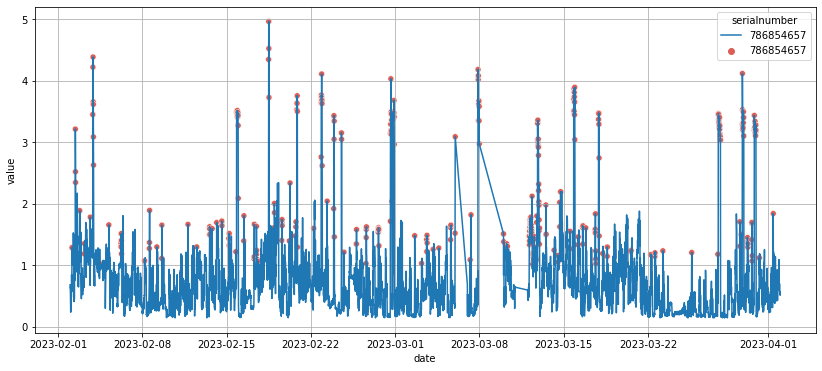

In [41]:
tmp_df = ami_df[ami_df['serialnumber']=='786854657'].sort_index().copy()
value_col = 'value'

rtpd = thresholding_algo(
    y=tmp_df['value'].tolist(), 
    lag=12,
    threshold=4, 
    influence=0.0, 
    signal_abs_threshold=1.0
)
tmp_df['signals'] = rtpd['signals']
#-------------------------
fig, ax = Plot_General.default_subplots()
sns.lineplot(ax=ax, x='date', y='value', hue='serialnumber', data=tmp_df)
sns.scatterplot(ax=ax, x='date', y='value', hue='serialnumber', data=tmp_df[tmp_df['signals']==1], palette='hls')
ax.grid(True, which='both')

In [42]:
df_T = tmp_df[value_col].copy() 
df_T = df_T.reset_index()
df_T=df_T.rename(columns={'starttimeperiod_local':'ds', 'value':'y'})

<AxesSubplot:xlabel='ds'>

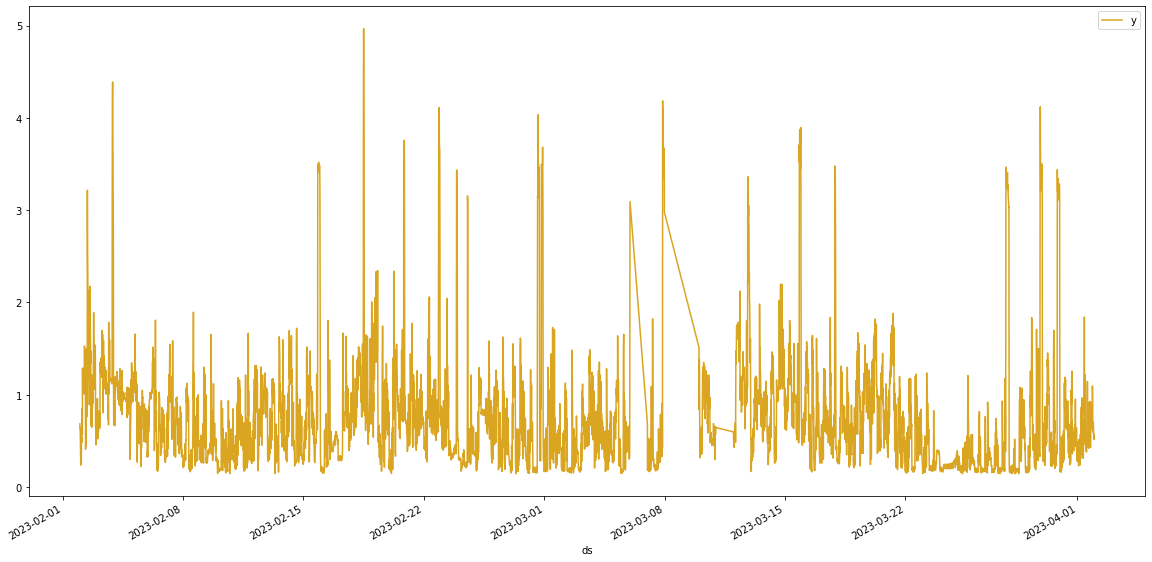

In [43]:
df_T.plot(x='ds', y='y', figsize=(20,10), color='goldenrod')

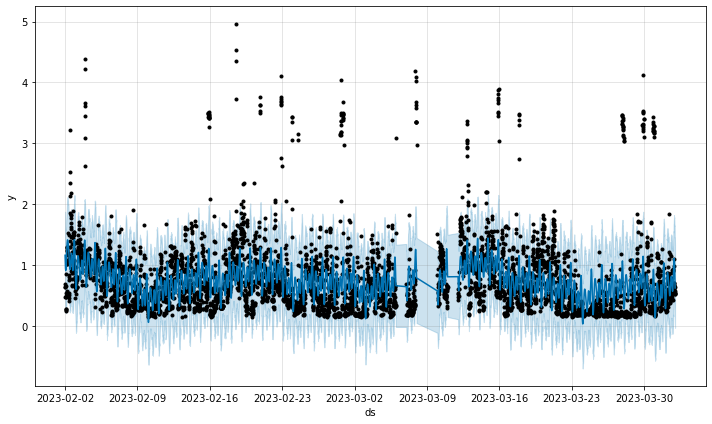

In [53]:
od = OutlierProphet(threshold=0.8)
od.fit(df_T)
#-----
future = od.model.make_future_dataframe(periods=0, freq='H', include_history=True)
forecast = od.model.predict(future)
fig = od.model.plot(forecast)

18:41:57 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing


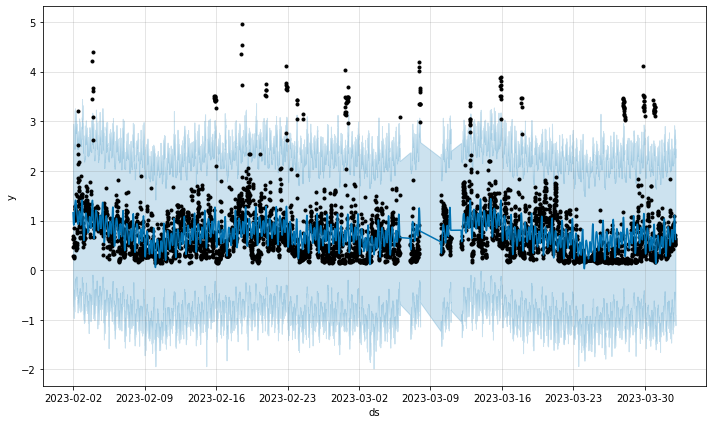

In [55]:
od = OutlierProphet(threshold=0.999)
od.fit(df_T)
#-----
future = od.model.make_future_dataframe(periods=0, freq='H', include_history=True)
forecast = od.model.predict(future)
fig = od.model.plot(forecast)

In [57]:
OutlierProphet?

In [58]:
od = OutlierProphet(threshold=0.999)
od.fit(df_T)
#-----
od_preds = od.predict(
    df_T,
    return_instance_score=True,
    return_forecast=True
)

18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
od_preds.keys()

dict_keys(['data', 'meta'])

In [61]:
od_preds['data'].keys()

dict_keys(['instance_score', 'feature_score', 'is_outlier', 'forecast'])

In [63]:
od_preds['data']['is_outlier']

,ds,is_outlier
0,2023-02-02 00:00:00,0
1,2023-02-02 00:15:00,0
2,2023-02-02 00:30:00,0
3,2023-02-02 00:45:00,0
4,2023-02-02 01:00:00,0
...,...,...
5271,2023-04-01 22:45:00,0
5272,2023-04-01 23:00:00,0
5273,2023-04-01 23:15:00,0
5274,2023-04-01 23:30:00,0


In [77]:
df_T[od_preds['data']['is_outlier']['is_outlier']==1]

,ds,y
42,2023-02-02 10:30:00,3.216
181,2023-02-03 21:15:00,3.452
182,2023-02-03 21:30:00,4.222
183,2023-02-03 21:45:00,4.388
184,2023-02-03 22:00:00,3.660
...,...,...
5077,2023-03-30 22:15:00,3.160
5078,2023-03-30 22:30:00,3.108
5079,2023-03-30 22:45:00,3.282
5080,2023-03-30 23:00:00,3.282


In [69]:
we = pd.merge(df_T, od_preds['data']['is_outlier'], left_on='ds', right_on='ds', how='inner')

In [71]:
we[we['is_outlier']==1]

,ds,y,is_outlier
42,2023-02-02 10:30:00,3.216,1
181,2023-02-03 21:15:00,3.452,1
182,2023-02-03 21:30:00,4.222,1
183,2023-02-03 21:45:00,4.388,1
184,2023-02-03 22:00:00,3.660,1
...,...,...,...
5077,2023-03-30 22:15:00,3.160,1
5078,2023-03-30 22:30:00,3.108,1
5079,2023-03-30 22:45:00,3.282,1
5080,2023-03-30 23:00:00,3.282,1


In [78]:
df_T[od_preds['data']['is_outlier']['is_outlier']==1]

,ds,y
42,2023-02-02 10:30:00,3.216
181,2023-02-03 21:15:00,3.452
182,2023-02-03 21:30:00,4.222
183,2023-02-03 21:45:00,4.388
184,2023-02-03 22:00:00,3.660
...,...,...
5077,2023-03-30 22:15:00,3.160
5078,2023-03-30 22:30:00,3.108
5079,2023-03-30 22:45:00,3.282
5080,2023-03-30 23:00:00,3.282


In [81]:
df_T

,ds,y
0,2023-02-02 00:00:00,0.684
1,2023-02-02 00:15:00,0.632
2,2023-02-02 00:30:00,0.636
3,2023-02-02 00:45:00,0.470
4,2023-02-02 01:00:00,0.276
...,...,...
5271,2023-04-01 22:45:00,0.528
5272,2023-04-01 23:00:00,0.538
5273,2023-04-01 23:15:00,0.574
5274,2023-04-01 23:30:00,0.514


In [80]:
df_T['y']

0       0.684
1       0.632
2       0.636
3       0.470
4       0.276
        ...  
5271    0.528
5272    0.538
5273    0.574
5274    0.514
5275    0.532
Name: y, Length: 5276, dtype: float64

<AxesSubplot:xlabel='ds', ylabel='y'>

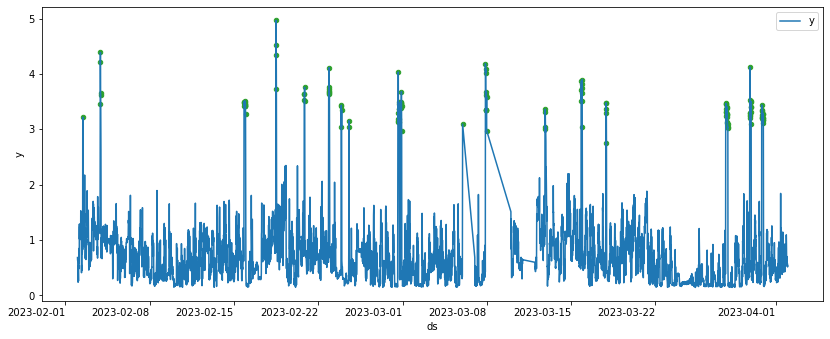

In [82]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
#-------------------------
df_T.plot(ax=ax, x='ds', y='y', color='tab:blue')
df_T[od_preds['data']['is_outlier']['is_outlier']==1].plot.scatter(
    ax=ax, x='ds', y='y', color='tab:green'
)
# ax.axhline(signal_abs_threshold, color='tab:red')
# ax.grid(True, which='both')
# ax.set_xlabel('Datetime', fontsize='xx-large', loc='right')
# ax.set_ylabel('kWh', fontsize='xx-large', loc='top')
# ax.set_title('EV', fontsize='xx-large')
# #-------------------------

In [95]:
od_preds['data']['forecast'].columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'y', 'score'],
      dtype='object')

<AxesSubplot:xlabel='ds', ylabel='y'>

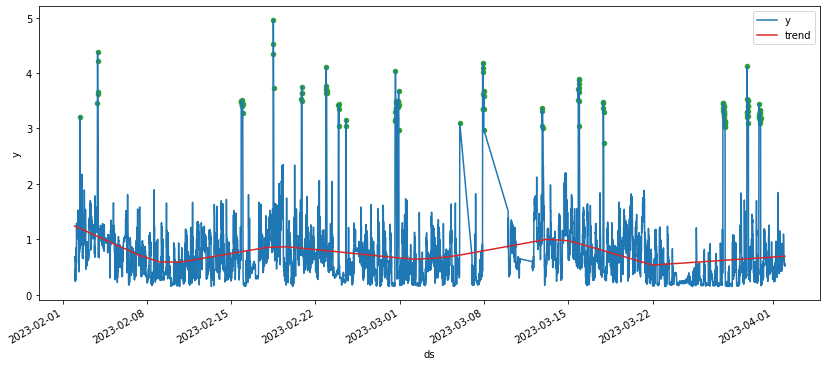

In [102]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
#-------------------------
df_T.plot(ax=ax, x='ds', y='y', color='tab:blue')
df_T[od_preds['data']['is_outlier']['is_outlier']==1].plot.scatter(
    ax=ax, x='ds', y='y', color='tab:green'
)
od_preds['data']['forecast'].plot(ax=ax, x='ds', y='trend', color='tab:red')

In [84]:
conn = Utilities.get_athena_prod_aws_connection()

In [85]:
sql = 'Select * from cds_ds_db.ev_tarf'

In [87]:
all_trff_dfs_NEW = pd.read_sql(sql, conn)

C:\Users\s346557\Anaconda3\envs\fbprophet\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [91]:
all_trff_dfs_NEW[all_trff_dfs_NEW['prem_nb'].isin(evs_prems)]['ev'].value_counts()

1    557
0    371
Name: ev, dtype: int64

In [92]:
all_trff_dfs_NEW[all_trff_dfs_NEW['prem_nb'].isin(non_prems)]['ev'].value_counts()

0    1406
Name: ev, dtype: int64